Myat Ma De May Phuu Ngon, 26002304901

#  I Project Objectives

The main goal of this project is to **forecast future air quality levels in Delhi**, focusing on dangerous pollutants such as **PM2.5** with different models, discussing and comparing the results, by analyzing historical time series data. 

Sub Objectives: 

Characterise the Series:

- Exploratory data analysis including:
   - Descriptive statistics
   - Time series plots
   - Stationarity checks
   - Seasonal decomposition

Model Training: 

- Statistical models:
    - ARIMA
    - SARIMA
    - Decomposition-based forecasting, etc

- Neural network-based models:
   - Recurrent Neural Networks (RNNs)
   - Long Short-Term Memory (LSTM)
   - Convolutional Neural Networks (CNNs) for time series modeling
   - MLP-based models


- Hyper-Parameter Tuning of the chosen model


#  II Project Questions

- How accurately can we forecast PM 2.5 concentrations in Delhi, and which time-series models deliver the best predictive performance?

- What strength and periodicity of trend/seasonality exist in relevant pollutants and meteorological features?

# III Data Source

Data was downloaded from Kaggle. There are a lot of CSV data, accounting for each region of India.

Among them, **Delhi dataset (DL019.csv)** was chosen so it had the least missing data.

https://www.kaggle.com/datasets/abhisheksjha/time-series-air-quality-data-of-india-2010-2023/data?select=DL001.csv


#  IV Data Description

## Air Quality Data of Delhi

**Data contains levels of multiple pollutants and meteorological features that were collected in India, Delhi from 2018 to 2023.**

The data has been collected from the Central Control Room for Air Quality Management, which indicates that it is a reliable and authoritative source.

**Time Period**: from 2018-02-01 to 2023-03-31

**Total Rows**: 45,230 (about 5 years of hourly data)

**Main Pollutants**:

PM2.5 (Particulate Matter 2.5) (ug/m3), PM10 (Particulate Matter 10) (ug/m3), NO (Nitric Oxide) (ug/m3), NO2 (Nitrogen Dioxide) (ug/m3), NOx (Nitrogen Oxides) (ppb), NH3 (Ammonia) (ug/m3), SO2 (Sulfur Dixoide) (ug/m3), CO (Carbon Monoixde) (ug/m3), Ozone (ug/m3), Benzene (ug/m3), Toluene (ug/m3)

**Other Meteorological Features**:

Temp (Temperature)(degree C), RH (Relative Humidity) (%), WS (Wind Speed)(m/s), WD (Wind Direction) (degree), SR (Solar Radiation) (W/mt2), BP(Barometric Pressure) (mmHg), AT (Air Temperature) (degree C), RF (Rainfall) (mm)


#  Imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.models import Model

#  Visualization of data

First thing first, we would like to see the raw data so data is plotted as line graphs.

## Visualization of Raw Data

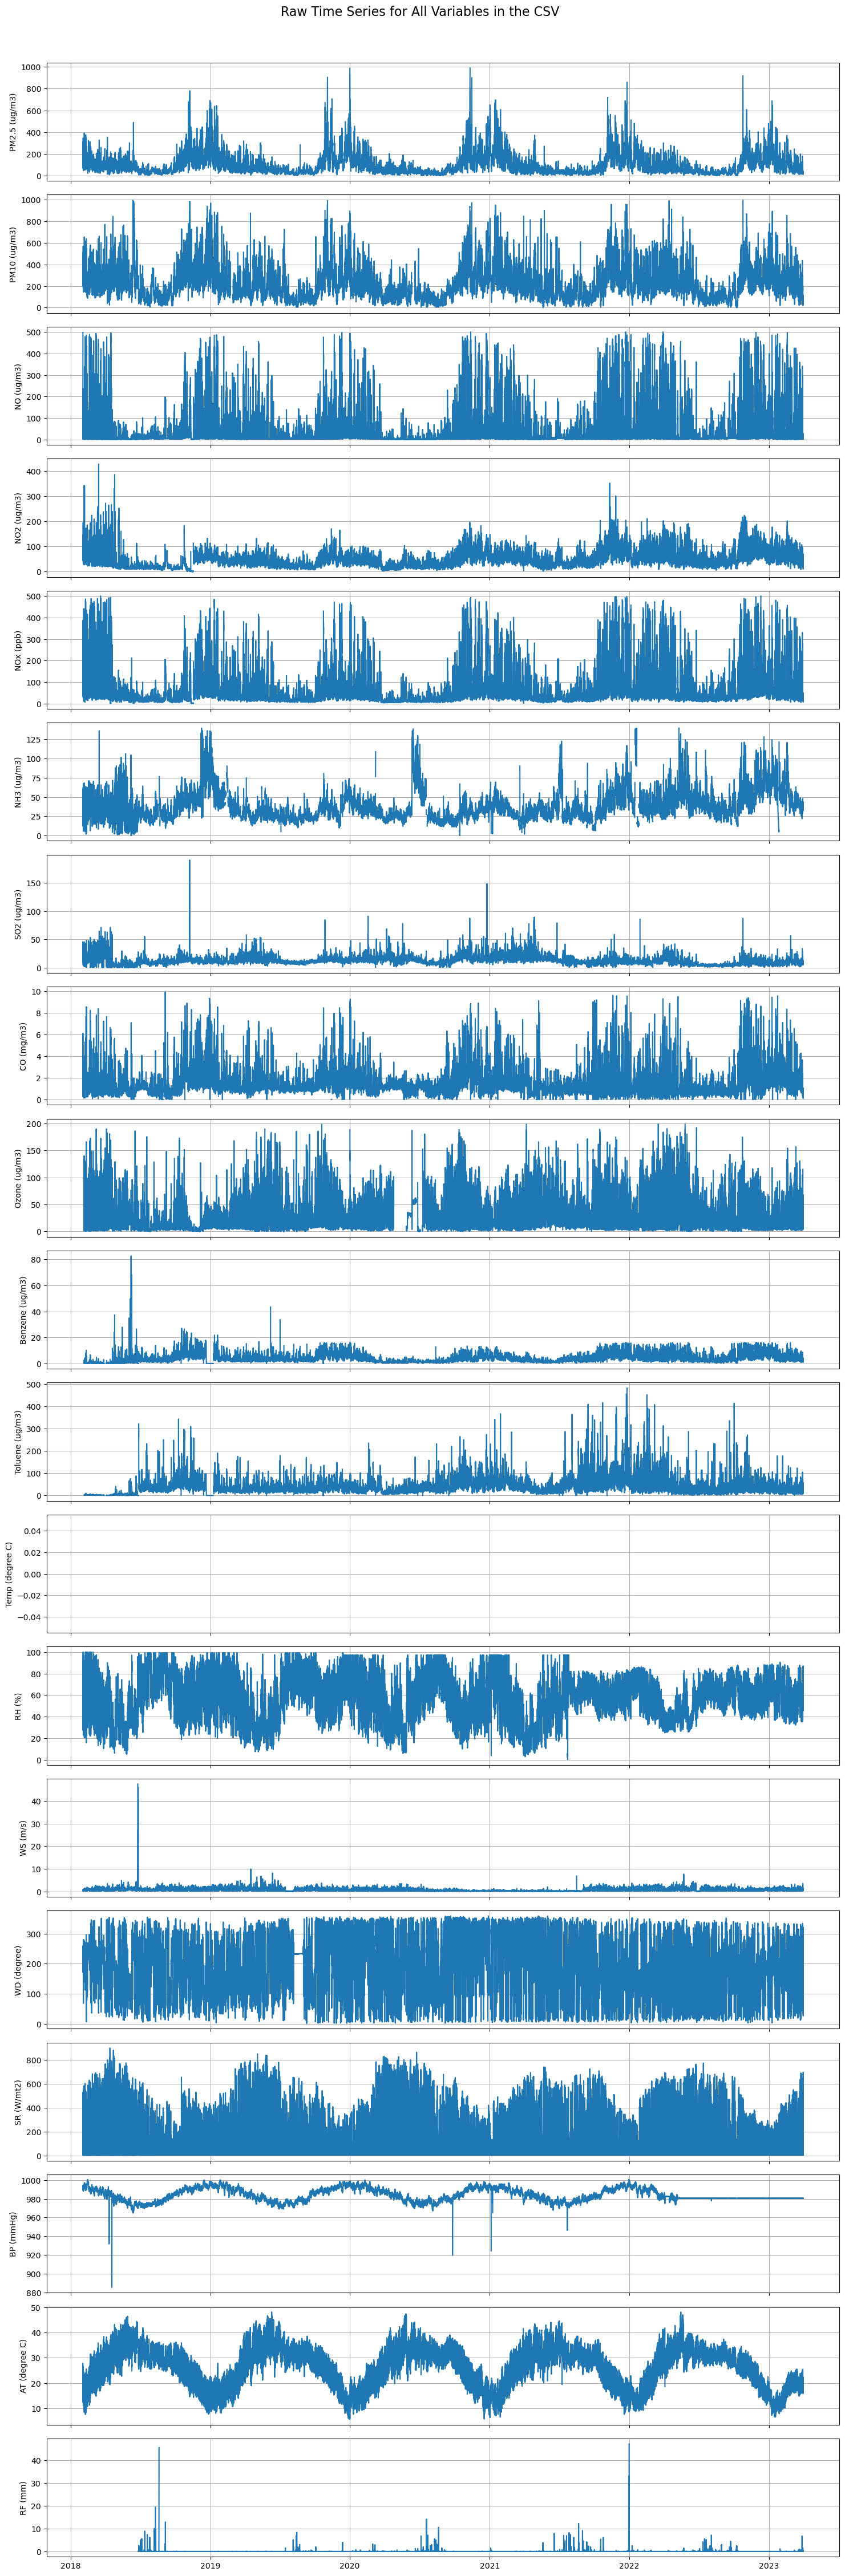

In [8]:
# Load the dataset
df = pd.read_csv("DL019.csv")

# Convert 'From Date' to datetime and set as index
df['From Date'] = pd.to_datetime(df['From Date'], errors='coerce')
df.set_index('From Date', inplace=True)
df.sort_index(inplace=True)

# Drop non-numeric columns except the datetime index
df_numeric = df.select_dtypes(include='number')

# Plot all numeric columns in subplots
num_cols = len(df_numeric.columns)
fig, axs = plt.subplots(num_cols, 1, figsize=(15, num_cols * 2.5), sharex=True)

for i, col in enumerate(df_numeric.columns):
    axs[i].plot(df_numeric.index, df_numeric[col])
    axs[i].set_ylabel(col)
    axs[i].grid(True)

plt.suptitle("Raw Time Series for All Variables in the CSV", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


**Analysis**:

Upon visualization of raw data, we can see some characteristics of each pollutants and features.

**PM2.5**

Shows repeated peaks, which suggests frequent episodes of high particulate matter.

This suggests potential seasonal or daily variation in pollution.

**PM10**

Closely follows the PM2.5 trend and seasonality but with higher magnitudes.

**NO**

Distinct spikes with regular intervals.

**NO2**

Generally stable with moderate fluctuation and occasional peaks.

**NOx**

Pattern similar to NO and NO2 with repeated peaks and fluctuations.

**NH3**

Fluctuating levels with noticeable spikes and some baseline consistency.

**SO2**

Low baseline values with sporadic spikes (might be outliers).

**CO**

Moderate fluctuations with many peaks across time.

**Ozone**

Variable levels with a dense cluster of peaks, possibly seasonal. Some data seem to be missing in the middle.

**Benzene**

Low and steady with rare peaks wich suggest outliers.

**Toluene**

Shows variability and increased peaks over time.

**T**

No data.

**RH**

Strong daily/seasonal fluctuation.

**WS**

Mostly consistent with occasional strong wind gusts. Outliers noted at between 2018 and 2019.

**WD**

High density indicates active wind data collection.

**SR**

Seasonal solar radiation trends are clearly seen.

**BP**

Smooth sinusoidal trends likely reflecting seasonal pressure patterns.

Occasional drops may indicate storms and are outliers. Data after mid 2022 seems stable.

**AT**

Strong seasonal cycles observed across years.

High summer peaks and low winter troughs reflect typical climatic variation.

**RF**

Mostly zero with rare but strong rainfall events.

Suggest sporadic rain or dry spells.



##  Zoomed In Visualization of Appropriate Raw Data 

There are two columns that say 'From Date' to 'To Date'. However, it is understood that it was an hourly data so we converted 'From Date' colum to datetime and set as index so that it is easier to process later.

10 key variables have been selected. Selected_columns has been created to keep relevant variables data to focus on deeper analysis.

Then the dataset is filtered to a specific time window (January 1 to February 1, 2021) and a 24-hour rolling average is calculated for each variable. Finally, it plots both the raw and smoothed data to visually compare short-term fluctuations and long-term trends.


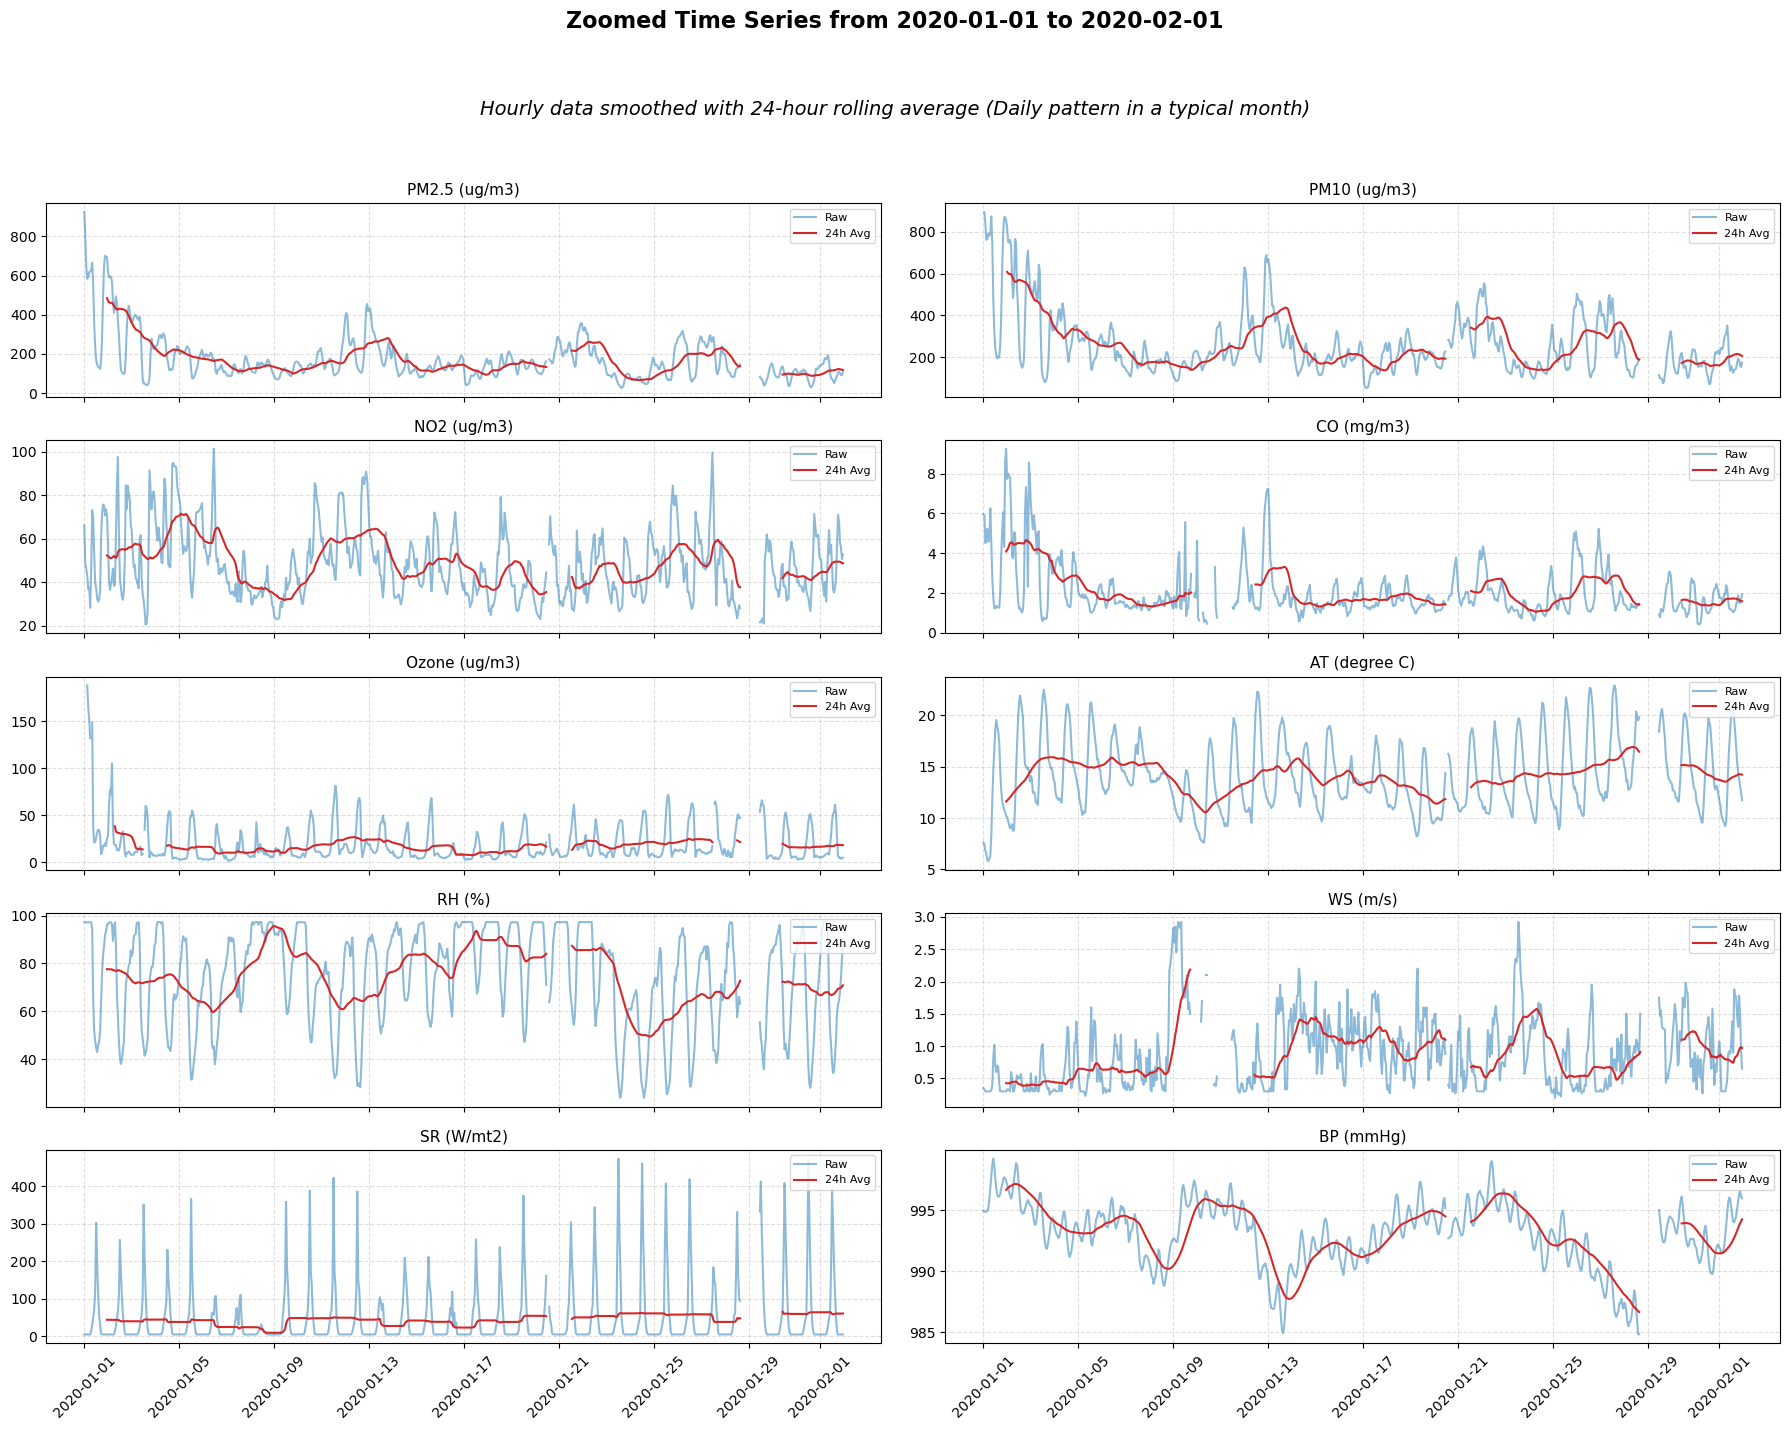

In [11]:
# Load and prepare data
df = pd.read_csv("DL019.csv")

# Convert 'From Date' to datetime and set as index
df['From Date'] = pd.to_datetime(df['From Date'], errors='coerce')
df.set_index('From Date', inplace=True)
df.sort_index(inplace=True)

# Selected key variables
selected_columns = [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)',
    'AT (degree C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)', 'BP (mmHg)'
]

df_selected = df[selected_columns]

# Zoom into a specific time window
# Change these dates to any range you want to zoom into
zoom_start = '2020-01-01'
zoom_end = '2020-02-01'
df_zoom = df_selected.loc[zoom_start:zoom_end]

# Compute rolling average for 24-hour window
df_smooth = df_zoom.rolling(window=24).mean()

# Layout: 2 columns × 5 rows
n_cols = 2
n_rows = (len(selected_columns) + 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3), sharex=True)
axs = axs.flatten() 

for i, col in enumerate(selected_columns):
    axs[i].plot(df_zoom.index, df_zoom[col], label='Raw', color='tab:blue', alpha=0.5)
    axs[i].plot(df_smooth.index, df_smooth[col], label='24h Avg', color='tab:red', linewidth=1.5)
    axs[i].set_title(col, fontsize=11)
    axs[i].grid(True, linestyle='--', alpha=0.4)
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='x', rotation=45)

# Hide unused subplots if any
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle(f"Zoomed Time Series from {zoom_start} to {zoom_end}", fontsize=16, fontweight='bold')

plt.figtext(0.5, 0.91, "Hourly data smoothed with 24-hour rolling average (Daily pattern in a typical month)", 
            ha='center', fontsize=14, style='italic')

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()


**Analysis of Zoomed Time Series (2020-01-01 to 2020-02-01):**

***Air Quality Variables***

**PM2.5**  
Sharp drop in concentration in early January followed by stable oscillations. The rolling average confirms a steep initial decline and short peaks in the middle.

**PM10**  
Similar to PM2.5 with higher magnitudes, indicating coarse particle activity. Several brief surges appear mid-month with a steady decline later.

**NO2**  
Significant variability and peak events. The smoothed trend stabilizes around 50–60 µg/m³.

**CO**  
Initial high concentrations taper off gradually. The average line shows decreasing emissions across the month.

**Ozone**  
Spiky raw data but the 24h average remains relatively flat.

***Meteorological Variables***

**AT**  
Strong daily cycles with a noticeable mid-month dip. The average shows a brief cooling period followed by a slight rise.

**RH**  
Day-night oscillations with saturated humidity levels nearing 100% on many days. The average peaks early in the month and dips slightly mid-month.

**WS**  
Short bursts of wind speed, especially after January 10 and 24. The average shows moderate wind variability across the month.

**SR**  
Daily sun cycle is prominent with sharp peaks. The average is steady, reflecting consistent solar exposure for the time of year.

**BP**  
Smooth atmospheric pressure waves with periodic rises and falls. The 24h average highlights a mid-month pressure drop and rebound.


##    Visualization of Hourly Patterns

Now we are going to zoom in the earlier plots and observe the hourly pattern to understand the daily fluctuations in pollutant levels. This may help to identify peak pollution hours and support selecting appropriate input features and time windows for forecasting models later.

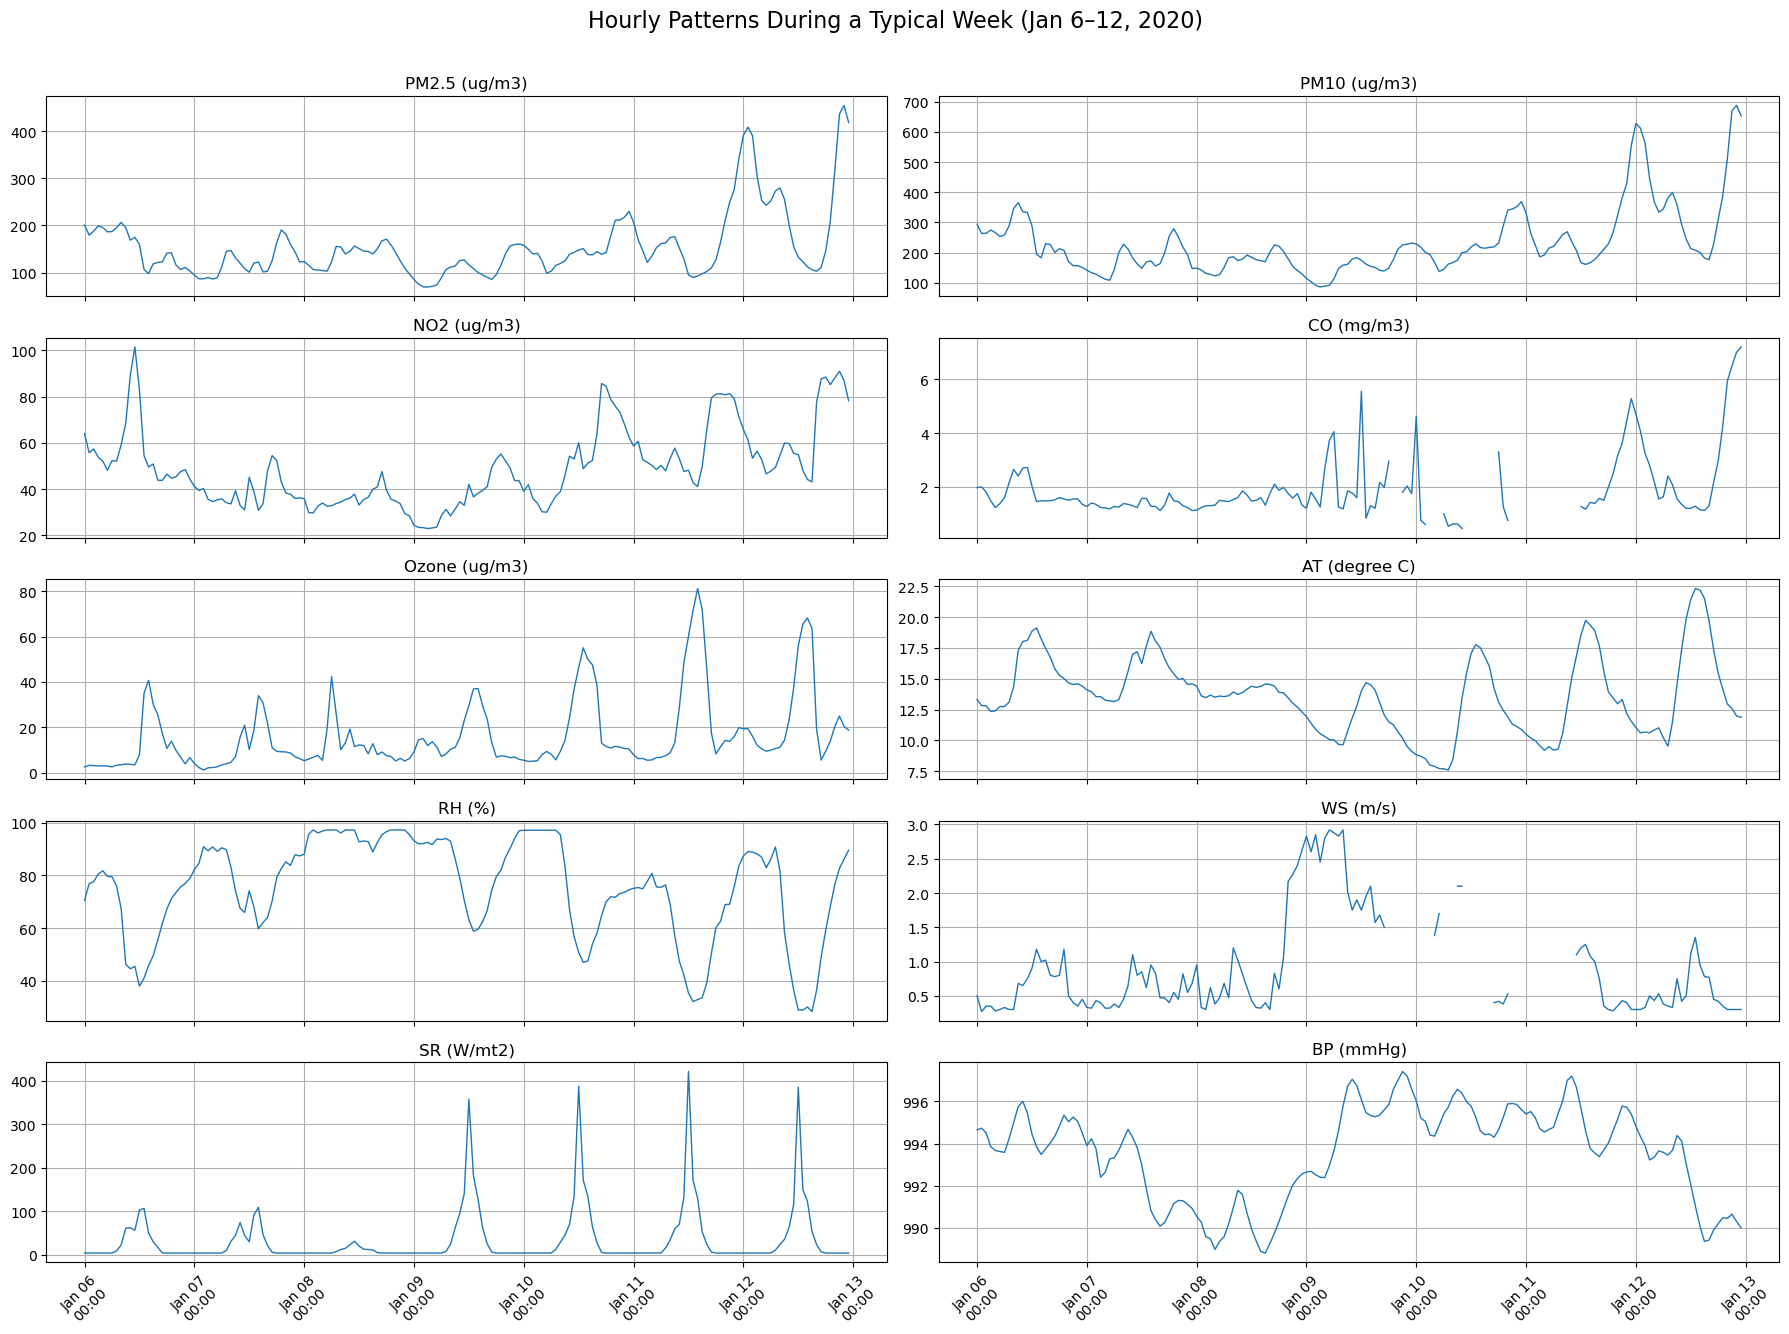

In [14]:
# Select relevant variables
selected_columns = [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)',
    'AT (degree C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)', 'BP (mmHg)'
]

# Filter a typical week
start_date = '2020-01-06'
end_date = '2020-01-12'
df_week = df.loc[start_date:end_date, selected_columns]

# Plot hourly time series for that week
fig, axs = plt.subplots(5, 2, figsize=(18, 14), sharex=True)
axs = axs.flatten()

for i, col in enumerate(selected_columns):
    axs[i].plot(df_week.index, df_week[col], color='tab:blue', linewidth=1)
    axs[i].set_title(col)
    axs[i].grid(True)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))
    axs[i].tick_params(axis='x', rotation=45)

plt.suptitle("Hourly Patterns During a Typical Week (Jan 6–12, 2020)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


### Hourly Patterns During a Typical Week (Jan 6–12, 2020)

**Air Quality Variables**
- **PM2.5** and **PM10** both show clear diurnal peaks, particularly in the early mornings and evenings, which suggest daily human activity such as traffic and domestic heating.
- **NO2** levels also follow a similar pattern, with twin peaks that align with rush hours, indicating vehicle emissions as a primary source.
- **CO** displays unstable but elevated night-time values, possibly due to incomplete combustion and stagnant air.
- **Ozone** shows an opposite pattern, with concentrations rising during midday and peaking in the afternoon, likely due to more sunlight leading to photochemical reactions.

**Meteorological Variables**
- **AT** follows a typical daily cycle with lows at night and highs in the afternoon.
- **RH** is inversely related to temperature, peaking at night and decreasing during the day.
- **WS** is generally higher in the daytime, helping with pollutant dispersion.
- **SR** rises sharply each day around sunrise and drops after sunset and as expected it is aligning well with daylight hours.
- **BP** remains relatively stable but exhibits minor fluctuations likely tied to passing weather systems.

From these graphs, we understand some typical urban air quality behavior and underline the importance of diurnal meteorological dynamics.


# V Summary Statistics

We used describe() to obtain a quick summary of each variable’s distribution (mean, std, min, max, etc.) and we can see the range and variability in the data.

In [17]:
# Basic descriptive stats for key variables
desc_stats = df_selected[['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'CO (mg/m3)', 'NO2 (ug/m3)', 'RH (%)', 'AT (degree C)']].describe()
desc_stats

PM2.5 (ug/m3)  PM10 (ug/m3)    CO (mg/m3)   NO2 (ug/m3)        RH (%)  \
count   44368.000000  43942.000000  43855.000000  44090.000000  44649.000000   
mean      101.888737    219.717030      1.472114     48.550997     59.651190   
std        97.643912    147.381967      1.185644     33.165856     21.800561   
min         1.000000      1.000000      0.000000      0.100000      0.400000   
25%        36.000000    108.337500      0.770000     23.500000     43.300000   
50%        67.000000    188.250000      1.120000     41.200000     61.000000   
75%       135.250000    296.250000      1.730000     65.420000     76.220000   
max       989.000000    995.000000      9.900000    426.970000    100.000000   

       AT (degree C)  
count   44573.000000  
mean       25.471122  
std         8.007762  
min         5.550000  
25%        19.150000  
50%        26.800000  
75%        31.170000  
max        48.200000

## Visualization with Histogram for Data Skewness

With histogram, we can see skewed distributions in the pollutants and meteorlogical features.

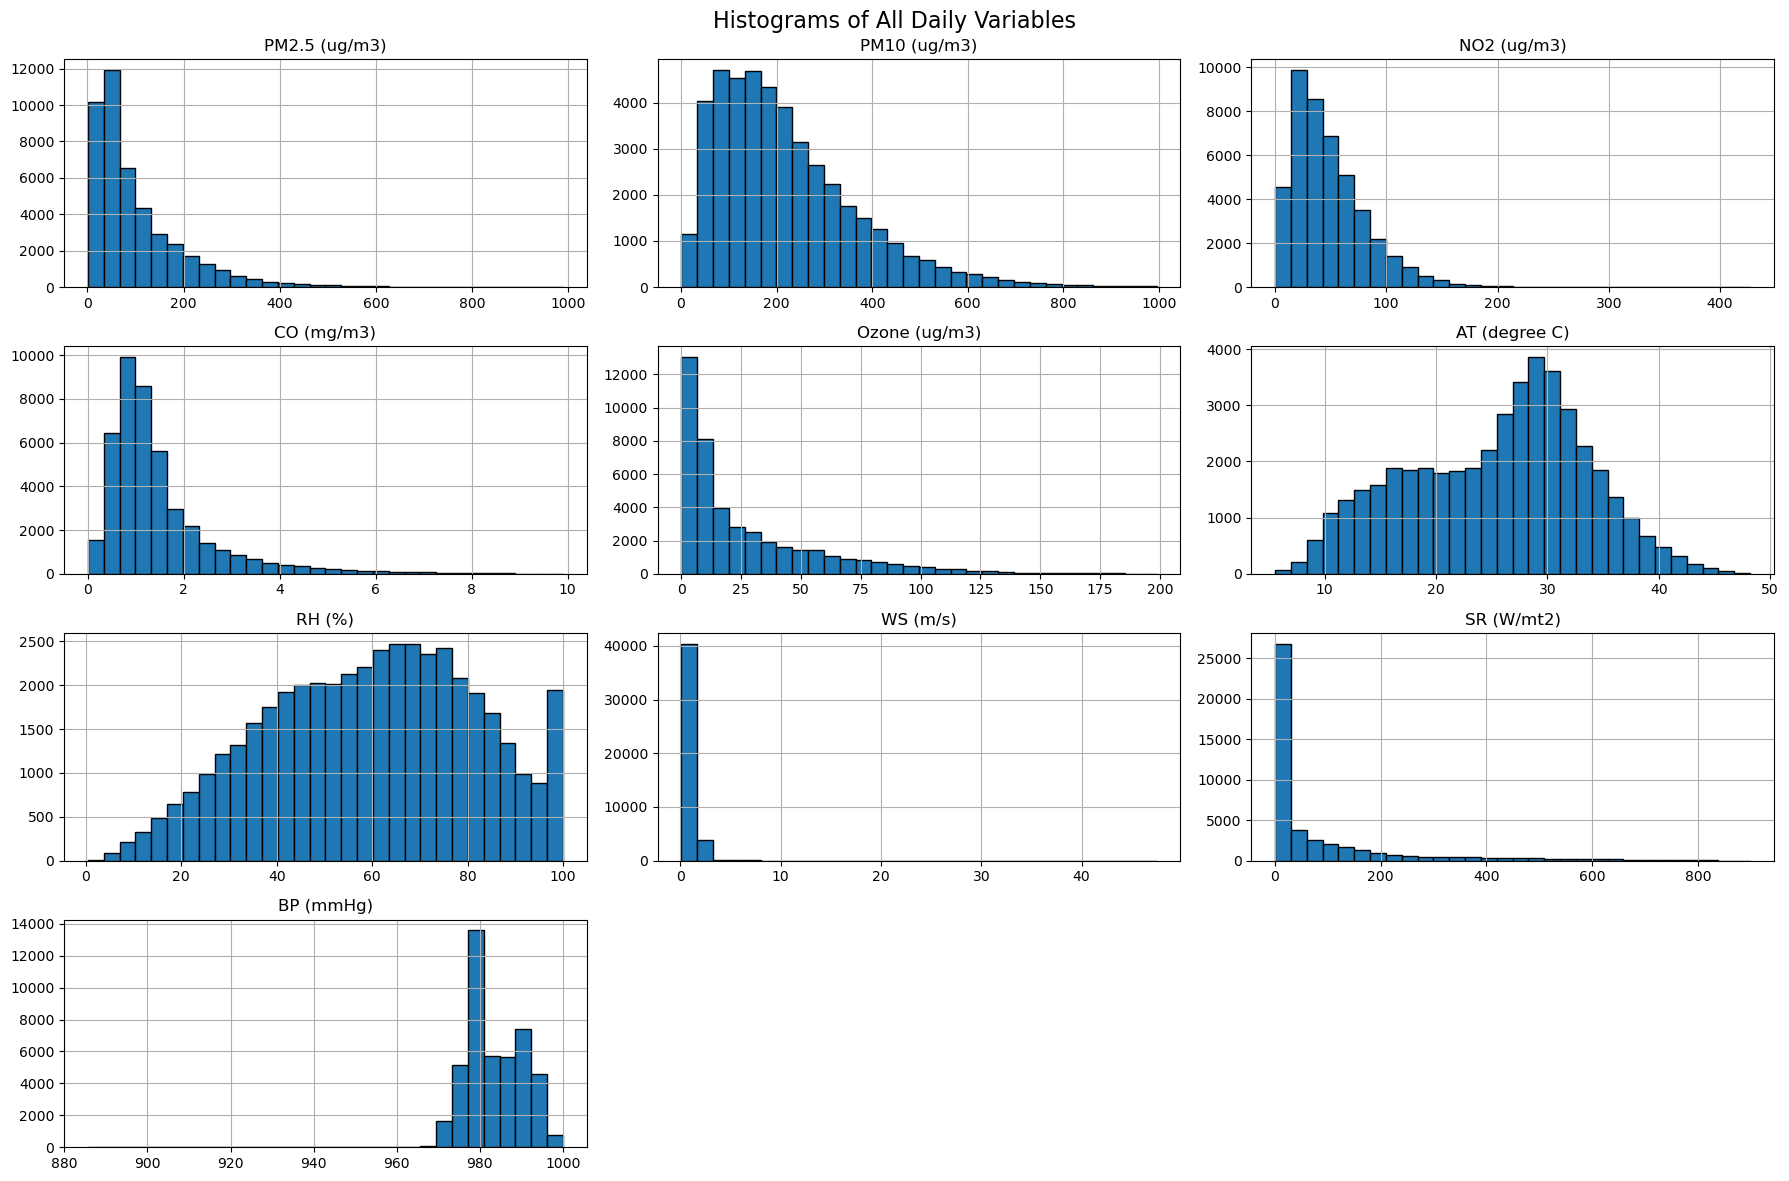

In [19]:
df_selected.hist(bins=30, figsize=(18, 12), edgecolor='black')
plt.suptitle("Histograms of All Daily Variables", fontsize=16)
plt.tight_layout()
plt.show()

**Analysis:**

**PM2.5**  

Strong right skew with a long tail; most values are below 200.  

Frequent low to moderate pollution levels with occasional severe spikes.

**PM10**  

Similar right-skewed distribution but with broader spread than PM2.5.  

Suggests more chances of extreme pollution.

**NO2**  

Moderate right skew, with values mostly between 0–100.  

As expected of NO2, might be due to vehicles or industrial impact.

**CO**  

Mild right skew; most values are under 3 mg/m³.  

Looks relatively stable.

**Ozone**  

Extremely right-skewed distribution with many low values and a long tail.  

Most days have low ozone, but there are a few days with unusually high concentrations.

**AT**

Multi-modal distribution, peaking around 15°C, 25°C, and 30°C.  

Could be seasonal temperature shifts throughout the year.

**RH**  

Slight left skew, mostly centered between 40% and 80%.  

Spikes near 100% suggest days with very high humidity, possibly due to rain or fog.

**WS**  

Extremely right-skewed; most wind speeds are below 2 m/s.  

Majority of days are calm, with few high wind events. Is it a storm?

**SR**  

Very strong right skew; most values are below 100 W/m².  

Frequent low solar radiation days, potentially due to cloud cover or pollution haze.

**BP**  

Nearly symmetric and bell-shaped, centered around 980 mmHg.  

Stable atmospheric pressure.

## Box Plot of Pollutants and Weather Features

With box plots, we can identify outliers, understand the spread of each feature in the raw air quality and meteorological dataset.


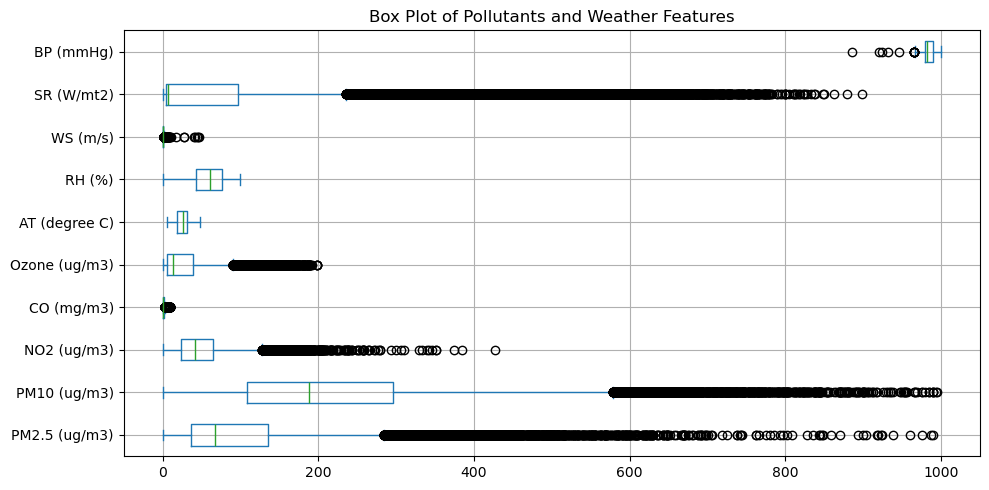

In [22]:
df_selected.plot(kind='box', figsize=(10, 5), grid=True, vert=False)
plt.title("Box Plot of Pollutants and Weather Features")
plt.tight_layout()
plt.show()

**Analysis: Box Plot of Pollutants and Weather Features**

**PM2.5**  
The distribution is right-skewed with a large number of high outliers. This suggests frequent pollution spikes possibly due to daily urban activities.

**PM10**  
Wider range than PM2.5 with even more high-end outliers. Indicates significant presence of coarse particles and dust events.

**NO2**  
Moderate range with many outliers above the upper whisker. Suggests traffic-related pollution with recurring short-term peaks.

**CO**  
The box is extremely compressed near zero, but a few high-value outliers exist. Most CO readings are low, with rare emission events causing spikes.

**Ozone**  
The majority of values lie in a narrow range, but extreme outliers stretch far above. This suggests generally low ozone with occasional surges, possibly in sunny periods.

**AT**  
Tightly packed and symmetric box with short whiskers, showing consistent temperature range. No significant outliers observed.

**RH**  
Relatively symmetric box, but several outliers exist on both the high and low ends. Suggests mostly stable humidity with a few extreme conditions.

**WS**  
Very narrow distribution centered near zero with multiple high-end outliers. Most days have low wind speeds, but occasional gusts appear as outliers.

**SR**  
Extremely skewed with a tight core and a long trail of upper outliers. Indicates most hours are low-sunlight with sharp peaks on clear days.

**BP**  
Narrow box with short whiskers and minimal outliers. Atmospheric pressure remains stable over time with few fluctuations.


#  VI Data Transformation

##  Missing Data

We are going to check how much data is missing in the selected columns.

Since, there are missing data, we need to fill in the data to reduce noise.

In [26]:
# Check missing data (count and percentage)
missing_count = df_selected.isnull().sum()
missing_percent = (df_selected.isnull().mean() * 100).round(2)

# Combine into one table
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent
})

print(missing_summary)


               Missing Count  Missing %
PM2.5 (ug/m3)            862       1.91
PM10 (ug/m3)            1288       2.85
NO2 (ug/m3)             1140       2.52
CO (mg/m3)              1375       3.04
Ozone (ug/m3)           2086       4.61
AT (degree C)            657       1.45
RH (%)                   581       1.28
WS (m/s)                 800       1.77
SR (W/mt2)               551       1.22
BP (mmHg)                619       1.37


**Analysis: Filling Missing Data & Visualization Interpretation**

We handled missing data in two stages:  
1. **Interpolation**: We fill missing values using interpolation for the missing values in the middle between two known data points. (eg. [10, NaN, 30], we are filling the missing NaN in the middle with interpolation)

2. **Backward and forward fill**: We used backward and forward fill to fill the missing values at the start and end of known data points. (eg. [NaN, 10, 20, NaN] in this data, we are using bfill() and ffill() for the NaN at the start and end).

After cleaning, we visualized the full time series using multi-line plots, grouped by pollutants and meteorological variables.  
While this approach made long-term trends easier to detect compared to individual line plots, the graphs appear visually congested due to the dataset's length and granularity.

Notably, we observed sudden spikes or potential **outliers** in variables like **Ozone**, **Wind Speed (WS)**, and **Barometric Pressure (BP)**. These may equire further attention during modeling and evaluation.


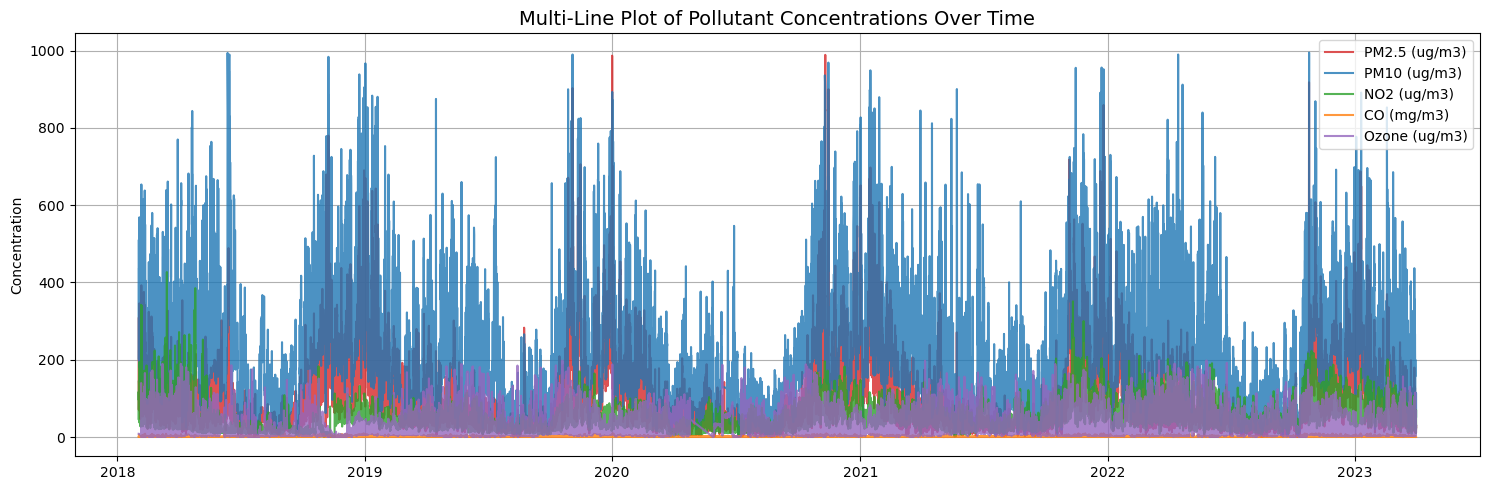

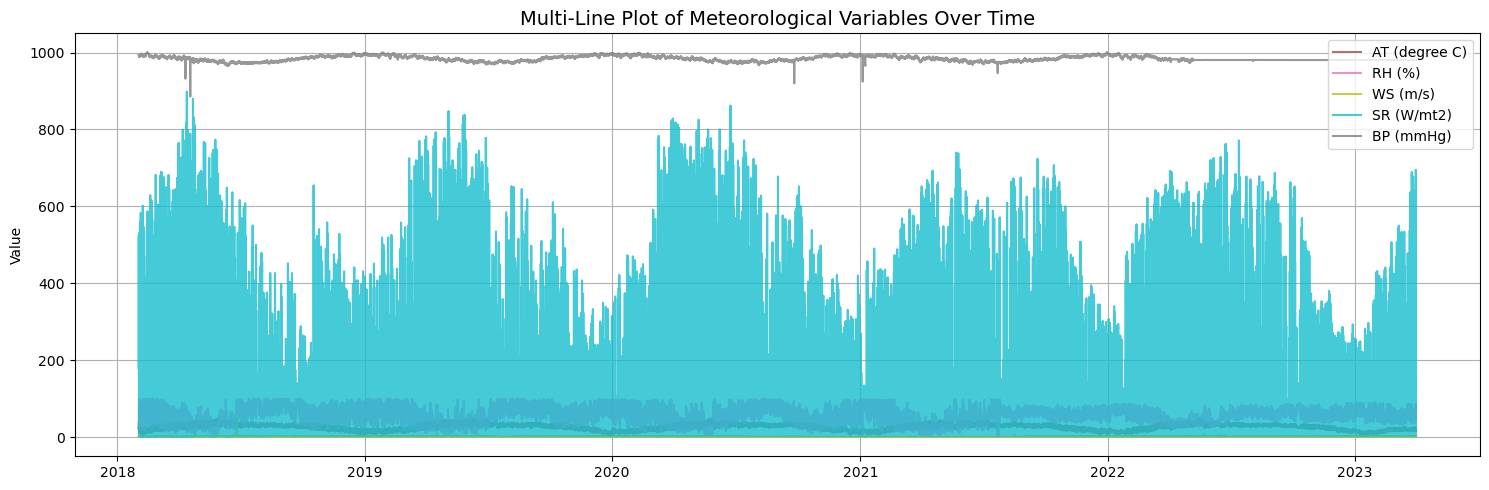

In [28]:
# Selected variables
selected_columns = [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)',
    'AT (degree C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)', 'BP (mmHg)'
]

# Clean missing values
df_selected = df[selected_columns]
df_cleaned = df_selected.interpolate(method='time')
df_cleaned = df_cleaned.bfill().ffill()

# Separate into pollutant and weather variables
pollutants = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)']
weather = ['AT (degree C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)', 'BP (mmHg)']

# Define custom color palettes
pollutant_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple']
weather_colors = ['tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan', 'tab:gray']

# Plot pollutants
plt.figure(figsize=(15, 5))
for i, col in enumerate(pollutants):
    plt.plot(df_cleaned.index, df_cleaned[col], label=col, color=pollutant_colors[i], alpha=0.8)
plt.title("Multi-Line Plot of Pollutant Concentrations Over Time", fontsize=14)
plt.ylabel("Concentration")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot meteorological variables
plt.figure(figsize=(15, 5))
for i, col in enumerate(weather):
    plt.plot(df_cleaned.index, df_cleaned[col], label=col, color=weather_colors[i], alpha=0.8)
plt.title("Multi-Line Plot of Meteorological Variables Over Time", fontsize=14)
plt.ylabel("Value")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


##    Monthly Mean of Selected Variables

**Analysis**

We made monthly average plots for the selected variables to reveal insights on seasonal cycles and long-term trends and alignment between variables.

PM10 and PM2.5 show periodic spikes—likely corresponding to specific seasons such as winter or post-monsoon, where pollution tends to accumulate. 

Meteorological variables like RH, AT, and SR show smoother sinusoidal patterns consistent with annual seasonal fluctuations. 

The relatively stable behavior of BP (mmHg) contrasts with the more variable pollutants, suggesting atmospheric pressure has limited short-term variation.

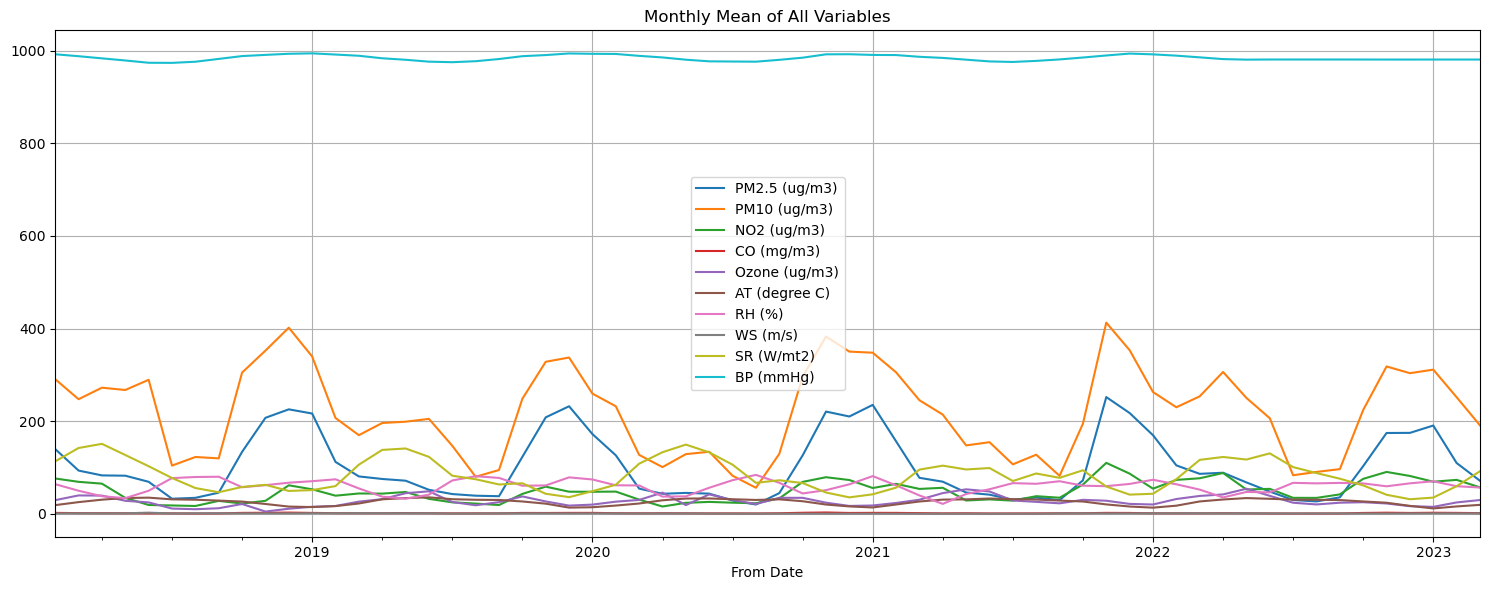

In [30]:
df_monthly = df_cleaned.resample('ME').mean()
df_monthly.plot(figsize=(15, 6), title='Monthly Mean of All Variables')
plt.grid(True)
plt.tight_layout()
plt.show()

##    Overall Mean Values of Selected Variables with Log Scale

**Analysis**

We made a log-scaled bar chart allows for a clearer comparison across variables with vastly different ranges. 

BP, PM10, and PM2.5 have the highest average values and they are dominating in the dataset. 

Meanwhile, variables like CO, WS, and AT have much lower mean values, which were previously hard to distinguish but visible thanks to the log scale transformation. 

This visualization helps in selecting which variables might require normalization or rescaling before modeling.

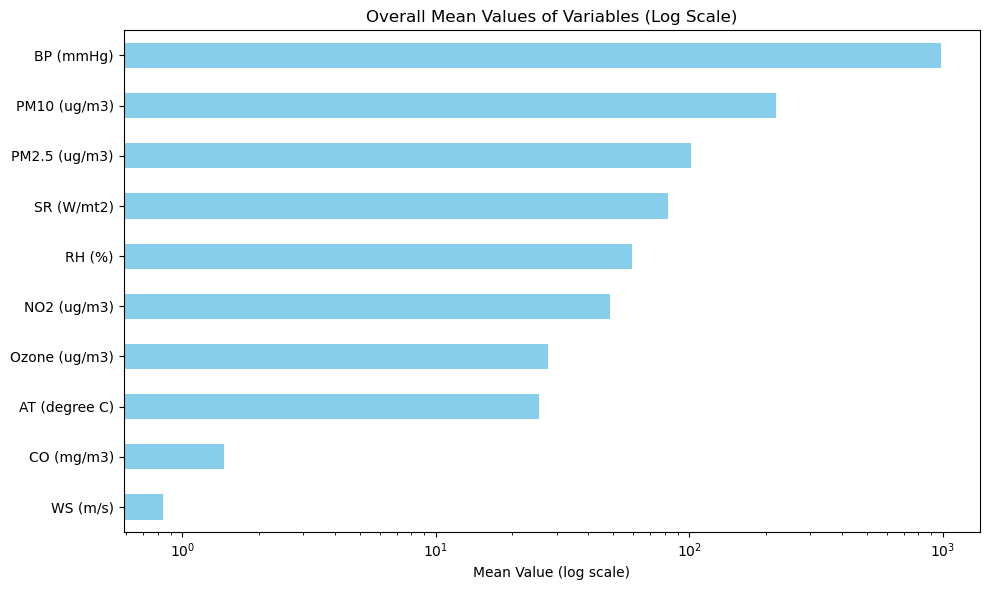

In [32]:
df_cleaned.mean().sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title("Overall Mean Values of Variables (Log Scale)")
plt.xlabel("Mean Value (log scale)")
plt.xscale('log')
plt.tight_layout()
plt.show()

##  Resampling daily data and Applying rolling average

After the monthly mean data, we are now curious on daily data so we resampled daily data to standardize time intervals.

By using the mean, we flattened the high frequency noise.

**7-Day Rolling Average of Daily Data**

To better observe medium-term patterns, we applied a 7-day rolling average to the daily-resampled data in filtered timezone (2019-2021).
This smoothing technique reduces noise and emphasizes meaningful trends across variables.

Compared to earlier raw or congested plots, we can see clearer seasonal behaviors and shifts in pollutant levels and weather features.

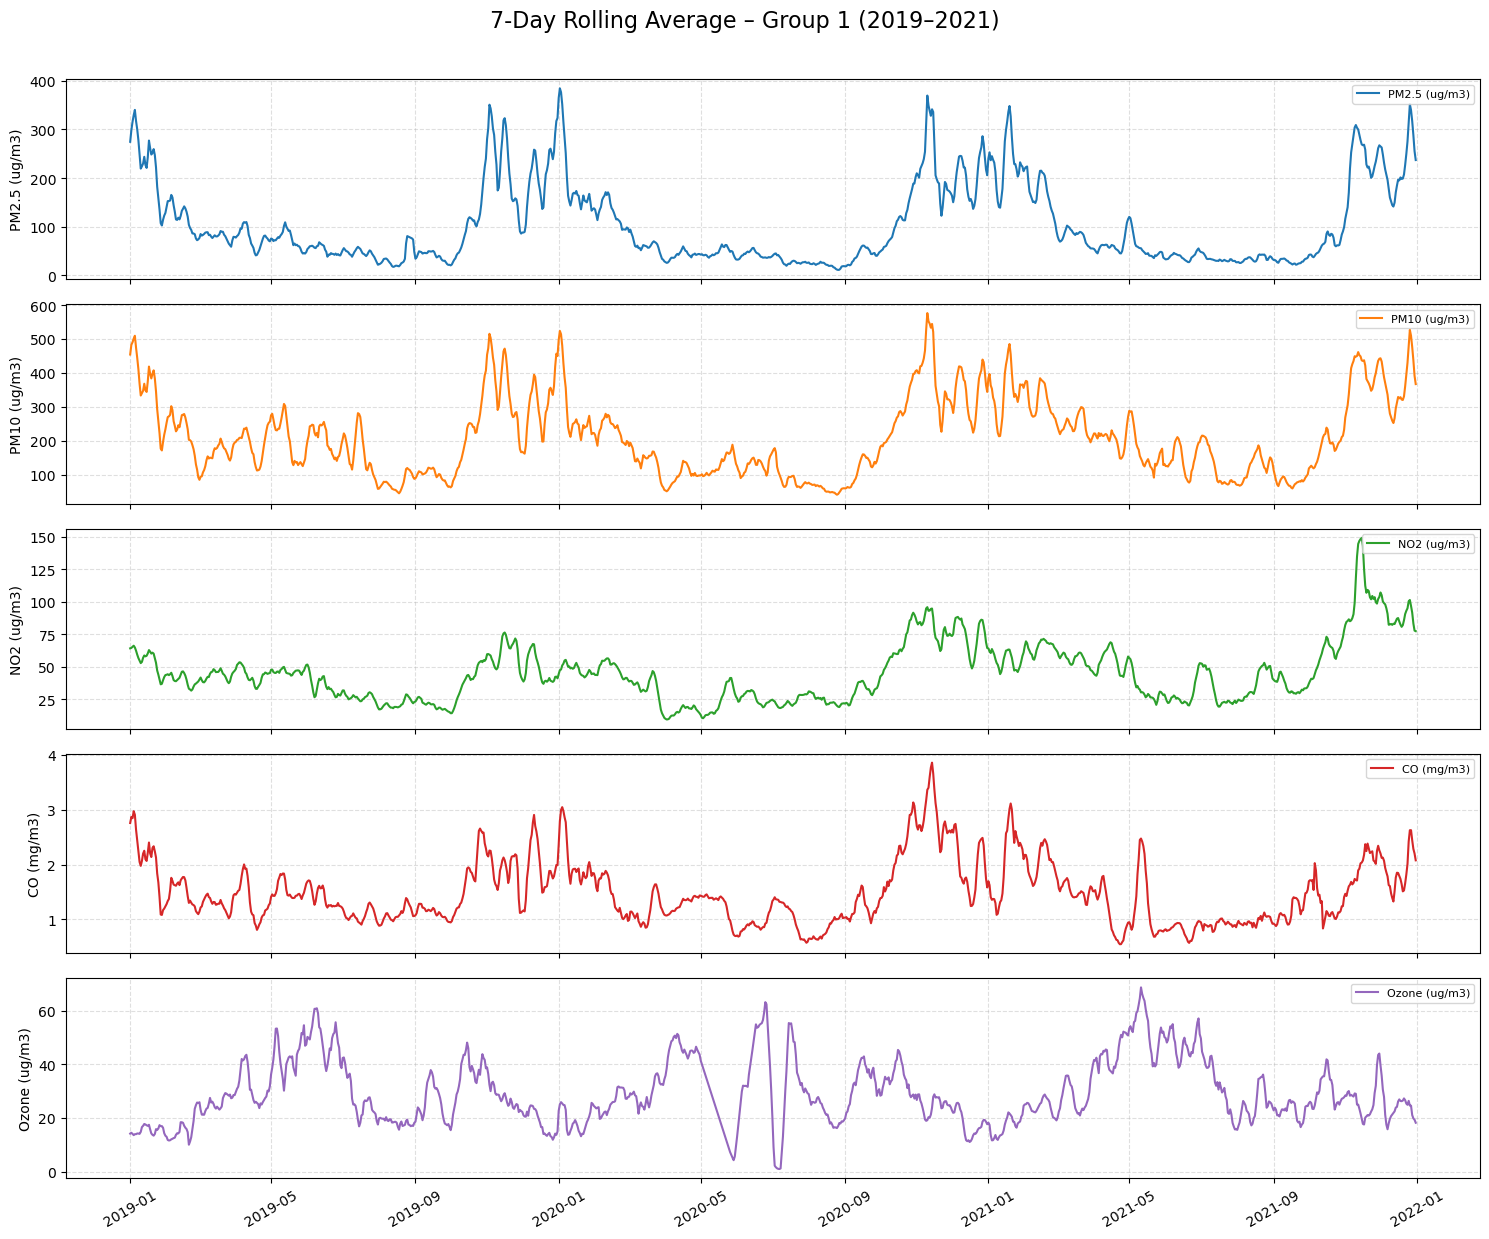

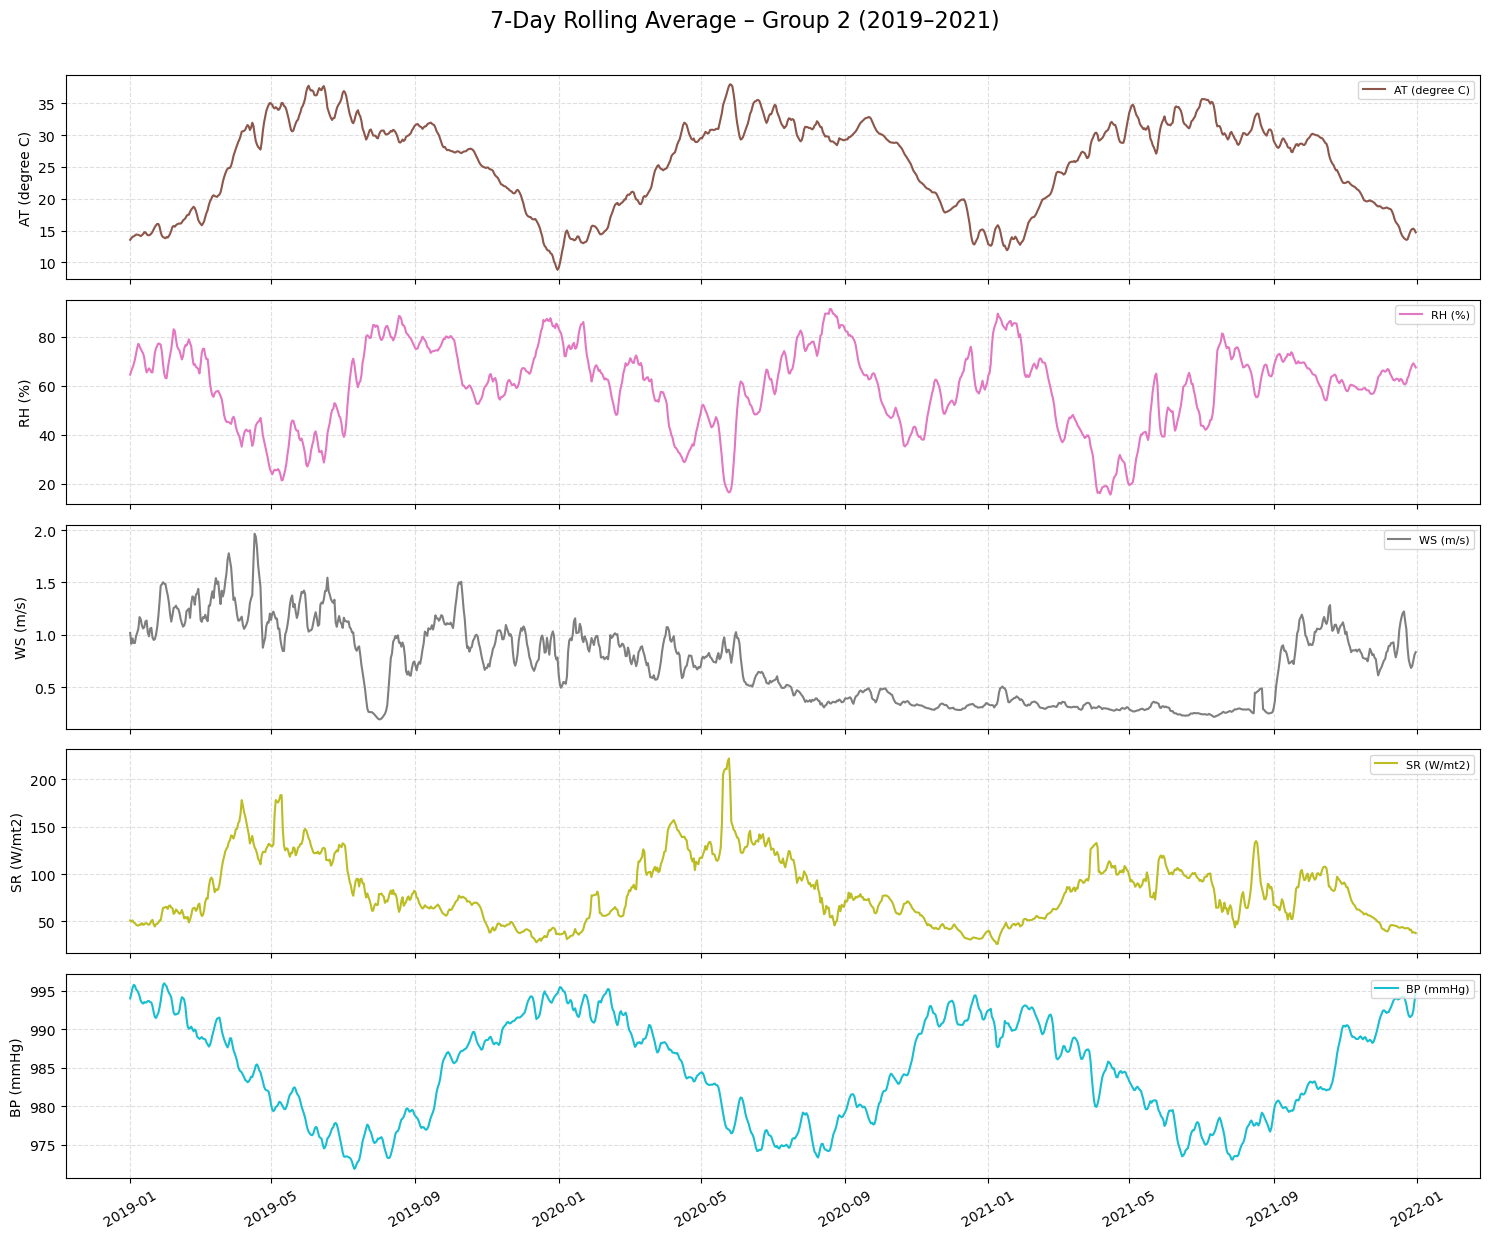

In [34]:
# Resample to daily average
df_daily = df_cleaned.resample('D').mean()

# Apply 7-day rolling average
df_smoothed = df_daily.rolling(window=7, min_periods=1).mean()

# Filter to 2019–2021
df_smoothed_filtered = df_smoothed.loc['2019-01-01':'2021-12-31']

# Split into two groups
group_1 = df_smoothed_filtered.iloc[:, :5]  # First 5 variables
group_2 = df_smoothed_filtered.iloc[:, 5:]  # Remaining 5 variables

# Plot group 1
fig, axs = plt.subplots(len(group_1.columns), 1, figsize=(15, 13), sharex=True)
for i, col in enumerate(group_1.columns):
    axs[i].plot(group_1.index, group_1[col], color=f'C{i}', linewidth=1.5)
    axs[i].set_ylabel(col)
    axs[i].grid(True, linestyle='--', alpha=0.4)
    axs[i].legend([col], loc='upper right', fontsize=8)
    axs[i].tick_params(axis='x', rotation=30)

plt.suptitle("7-Day Rolling Average – Group 1 (2019–2021)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Plot group 2
fig, axs = plt.subplots(len(group_2.columns), 1, figsize=(15, 13), sharex=True)
for i, col in enumerate(group_2.columns):
    axs[i].plot(group_2.index, group_2[col], color=f'C{i+5}', linewidth=1.5)
    axs[i].set_ylabel(col)
    axs[i].grid(True, linestyle='--', alpha=0.4)
    axs[i].legend([col], loc='upper right', fontsize=8)
    axs[i].tick_params(axis='x', rotation=30)

plt.suptitle("7-Day Rolling Average – Group 2 (2019–2021)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


**Analysis: 7-Day Rolling Average (2019–2021): Seasonal and Trend Insights**

Focusing on the 3-year window from 2019 to 2021 helps us uncover consistent seasonal trends and longer-term shifts in our variables.

**Group 1 – Pollutants**
- **PM2.5** and **PM10** show repeating annual peaks during winter seasons, indicating *persistent seasonality*.
- **NO2** levels slightly decline over the years.
- **CO** remains relatively low and flat, with minor seasonal variation.
- **Ozone** increases consistently during summer months.

**Group 2 – Meteorological Factors**
- **AT** follows a clear sinusoidal *seasonal cycle*, with cold winters and warm summers each year.
- **RH** exhibits sharp peaks during monsoon months, aligning with expected seasonal rainfall.
- **WS** and **SR** show mild seasonal fluctuations. **SR** peaks in mid-year, while **WS** remains mostly low with some short bursts.
- **BP** stays remarkably stable across seasons, with only slight variation.

**To summarize, seasonal patterns are observed in PM2.5, PM10, Ozone, AT, RH and SR.**


##  Correlation Matrix

We wanted to see what features are correlated so we perform a correlation matrix to see which features we can use in the models.


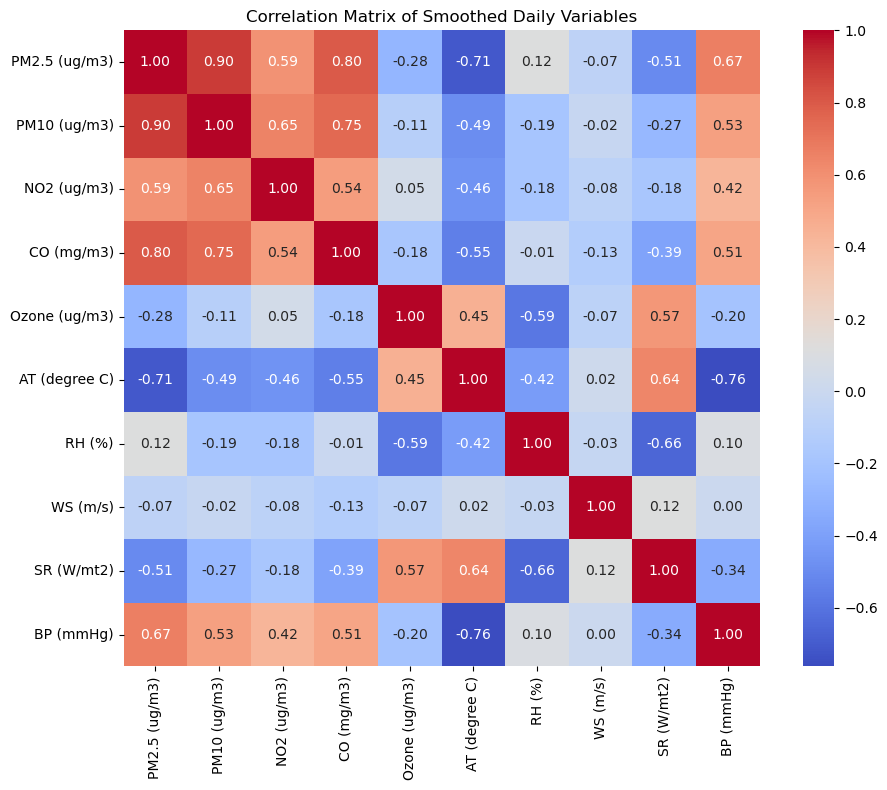

In [37]:
# Compute correlation matrix from smoothed daily data
correlation_matrix = df_smoothed.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Smoothed Daily Variables")
plt.tight_layout()
plt.show()


**Analysis:**

**Strong Positive Correlations**

PM2.5 & PM10 (ρ = 0.90): strong correlation

PM2.5 & CO (ρ = 0.80): strong correlation, rise together possibly due to vehicle emissions or combustion.

NO2 & PM10 / CO (ρ ≈ 0.54–0.65): NO2 shares common emission sources with particulates and CO like traffic-related pollution.

**Strong Negative Correlations**

PM2.5 & AT (ρ = -0.71) and PM10 & AT (ρ = -0.49): pollution levels are higher when temperature is lower.

AT & BP (ρ = -0.76): strong inverse relationship, as temperature rises, atmospheric pressure tends to drop.

Ozone & RH (ρ = -0.59): high humidity correlates with lower ozone, possibly because moist conditions stop ozone formation from sunlight-driven photochemical reactions.

**Near-Zero Correlation**
WS is nearly uncorrelated with most variables:


**Conclusion**

From this matrix, we can confidently use **PM10, CO, and AT** as predictors for **PM2.5** due to strong correlations.

We can exclude wind speed and humidity, or use nonlinear models to better capture their indirect influence.

# Stationarity Tests: ADF and KPSS

To determine whether a time series is stationary (if mean and variance do not change over time), we conducted two tests:

#### Augmented Dickey-Fuller (ADF) Test

**Null Hypothesis (H0)**: the series has a unit root/ it is non-stationary.

**Alternative Hypothesis (H1)**: the series is stationary.

**Interpretation**:
If p-value < 0.05, reject H0 so the series is likely stationary.

If p-value ≥ 0.05, fail to reject H0 so the series is non-stationary.

---

#### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

**Null Hypothesis (H0)**: The series is stationary.

**Alternative Hypothesis (H1)**: The series is non-stationary.

**Interpretation**:

If p-value < 0.05, reject H0 so the series is non-stationary.

If p-value ≥ 0.05, fail to reject H0 so the series is likely stationary.


In [41]:
# Variables to test
variables_to_test = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'AT (degree C)']

# Prepare a summary table
results = []

for var in variables_to_test:
    series = df_smoothed[var].dropna()

    # ADF Test
    adf_stat, adf_pval, _, _, adf_crit, _ = adfuller(series)
    
    # KPSS Test
    kpss_stat, kpss_pval, _, kpss_crit = kpss(series, regression='c', nlags="auto")

    results.append({
        'Variable': var,
        'ADF Test Statistic': round(adf_stat, 4),
        'ADF p-value': round(adf_pval, 4),
        'ADF Result': 'Stationary' if adf_pval < 0.05 else 'Non-Stationary',
        'KPSS Test Statistic': round(kpss_stat, 4),
        'KPSS p-value': round(kpss_pval, 4),
        'KPSS Result': 'Stationary' if kpss_pval > 0.05 else 'Non-Stationary'
    })

# Convert to DataFrame
stationarity_summary = pd.DataFrame(results)
print(stationarity_summary)


        Variable  ADF Test Statistic  ADF p-value  ADF Result  \
0  PM2.5 (ug/m3)             -4.1675       0.0007  Stationary   
1   PM10 (ug/m3)             -4.1334       0.0009  Stationary   
2    NO2 (ug/m3)             -3.6335       0.0052  Stationary   
3     CO (mg/m3)             -4.1957       0.0007  Stationary   
4  AT (degree C)             -3.2913       0.0153  Stationary   

   KPSS Test Statistic  KPSS p-value     KPSS Result  
0               0.0579          0.10      Stationary  
1               0.0993          0.10      Stationary  
2               1.5274          0.01  Non-Stationary  
3               0.1073          0.10      Stationary  
4               0.1761          0.10      Stationary  


/var/folders/__/y1bbp9fd7_s9sy4sdr014_540000gn/T/ipykernel_73779/3255029221.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pval, _, kpss_crit = kpss(series, regression='c', nlags="auto")
/var/folders/__/y1bbp9fd7_s9sy4sdr014_540000gn/T/ipykernel_73779/3255029221.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pval, _, kpss_crit = kpss(series, regression='c', nlags="auto")
/var/folders/__/y1bbp9fd7_s9sy4sdr014_540000gn/T/ipykernel_73779/3255029221.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, _, kpss_crit = kpss(series, regression='c', nlags="auto")
/var

**Analysis:**

Since ADF and KPSS have opposite null hypotheses, we are using both to draw a more robust conclusion.

If both says stationary, that means we have high confidence to say the series is stationary.

If they disagree, that means the series may be trend stationary or require differencing.


Problem with NO2 where ADF says it's stationary, but KPSS says it's not. This mismatch suggests it might still have some trend or drift.

### Differencing for NO2
First-order differencing is applied to fix.

In [44]:
# Create differenced version of NO2
df_smoothed['NO2_diff'] = df_smoothed['NO2 (ug/m3)'].diff().dropna()

# Test again after differencing
no2_diff = df_smoothed['NO2_diff'].dropna()

# ADF
adf_stat, adf_pval, *_ = adfuller(no2_diff)
print(f"NO2_diff ADF p-value: {adf_pval:.4f}")

# KPSS
kpss_stat, kpss_pval, *_ = kpss(no2_diff, regression='c', nlags='auto')
print(f"NO2_diff KPSS p-value: {kpss_pval:.4f}")


NO2_diff ADF p-value: 0.0000
NO2_diff KPSS p-value: 0.1000


/var/folders/__/y1bbp9fd7_s9sy4sdr014_540000gn/T/ipykernel_73779/1254959783.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(no2_diff, regression='c', nlags='auto')


**Analysis:**

The issue was that the test statistic was well below the KPSS critical range so the p-value is just capped at 0.1, but it's actually higher and assumed that differenced NO2 is now stationary based on both tests. 
We will be using NO2_diff in the future.

#  Decomposition

STL (Seasonal-Trend decomposition using LOESS) splits the time series of each selected variable into Trend, Seasonality, and Residual components. As we have paid deep focus on trends and seasonalities earlier, we would like to focus on residual more here.

The residual component is essential as it contains the unexplained noise which is not captured by trend or seasonality. 
Upon analyzing these we can obtain:

Whether model has captured most of the structure.

If there’s still patterned noise which might help from further modeling like ARIMA.

Next, we will come back to the residue to plot ACF/PACF of residuals and test for white noise with the goal to train ARIMA.

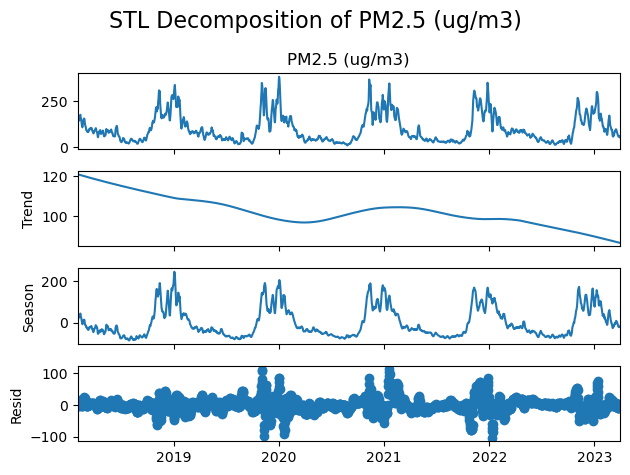

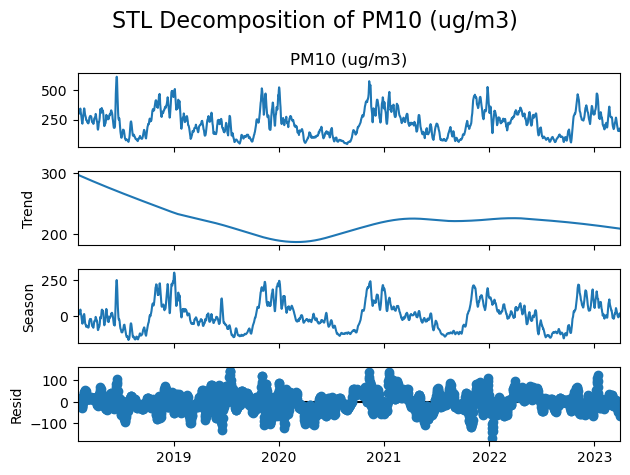

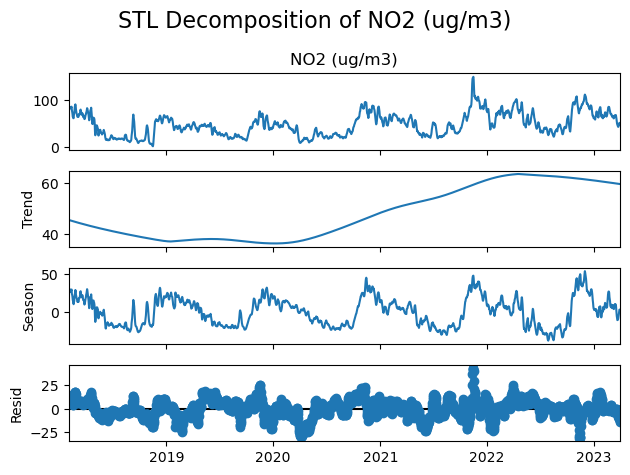

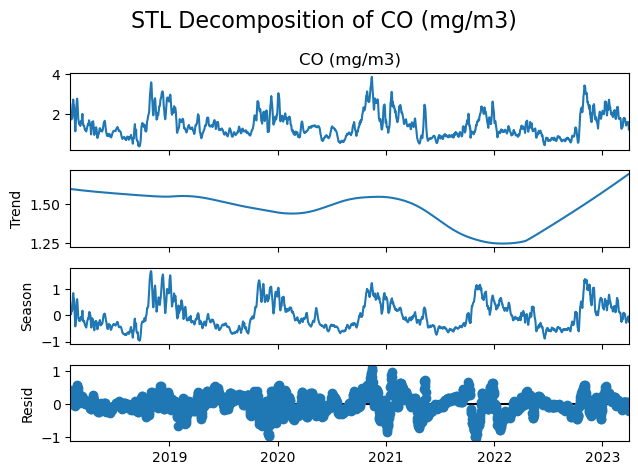

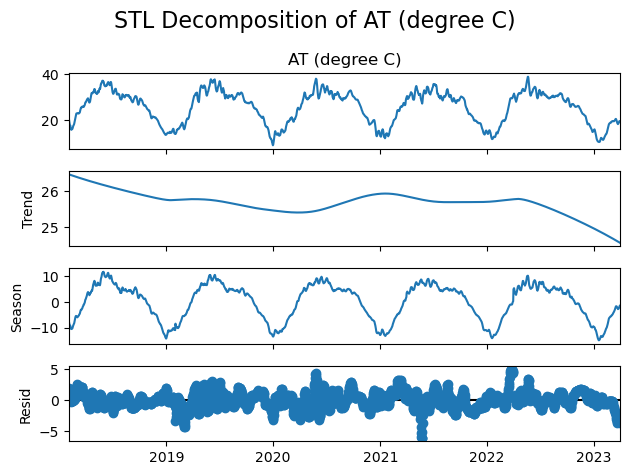

In [47]:
# List of important variables to decompose
variables_to_decompose = [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'AT (degree C)'
]

# Apply STL decomposition and plot results
for var in variables_to_decompose:
    series = df_smoothed[var].dropna()

    # STL assumes seasonal period; for daily data, 365 is a good starting point
    stl = STL(series, period=365)
    result = stl.fit()

    # Plot each component
    result.plot()
    plt.suptitle(f"STL Decomposition of {var}", fontsize=16)
    plt.tight_layout()
    plt.show()

**Analysis:**

**PM2.5**

**Trend**: downward trend

**Seasonality**: Strong annual cycles with winter peaks

**Residual**: Contains high short-term variability, pointing to pollution spikes from specific events.


**PM10**

**Trend**: Similar downward trend as PM2.5

**Seasonality**: Clearly defined peaks around the same periods every year so it suggests consistent seasonal effects.

**Residual**: Noisy with sharp deviations, likely due to dust, festivals, or urban activity.


**NO2**

**Trend**: Displays an increase from around 2020 to 2022, potentially linked to rising traffic post-COVID.

**Seasonality**: Recurring patterns, but less pronounced than particulate matters.

**Residual**: Contains some spikes, suggesting episodic NO2 surges from local emissions or traffic congestion.


**CO**

**Trend**: Generally stable with a recent upward turn post-2021 like NO2.

**Seasonality**: Mild seasonal variation, weaker than PM or NO2.

**Residual**: Very low noise; indicates consistent CO levels with few abrupt changes.


**AT**

**Trend**: Downward trend, downward turn after 2022, but mostly stable.

**Seasonality**: Strong, smooth sinusoidal cycles, classic yearly temperature patterns.

**Residual**: Low magnitude—most of the variation is captured by trend and seasonality.

## Preparation for modelling
### ACF and PACF Analysis of PM2.5

We would like to focus on our objective: PM2.5 level.
Before starting model development, we want to make sure the appropriate parameters.
We visualized the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** for the 7-day smoothed PM2.5 time series.


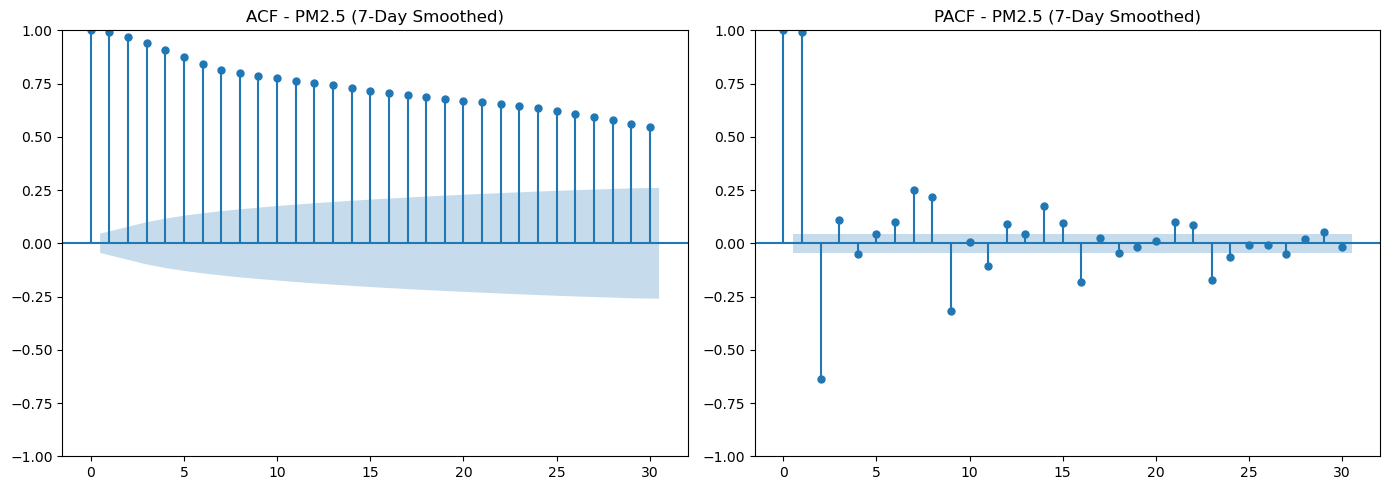

In [50]:
# Use smoothed and cleaned PM2.5 series
series = df_smoothed['PM2.5 (ug/m3)'].dropna()

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(series, lags=30, ax=axes[0])
plot_pacf(series, lags=30, ax=axes[1])
axes[0].set_title("ACF - PM2.5 (7-Day Smoothed)")
axes[1].set_title("PACF - PM2.5 (7-Day Smoothed)")
plt.tight_layout()
plt.show()


**Result Analysis:**

- The **ACF plot** shows a relatively slow decay, which may suggest non-stationarity at first glance. However, **ADF and KPSS tests confirm stationarity**, so this is likely due to strong signal persistence. This indicates **MA (q)** component in model.
- The **PACF plot** displays a clear cut-off after lag 1, indicating a strong **AR (p)** component of order 1.
- These findings help inform our initial ARIMA model configuration, leading to a starting choice of **ARIMA(1, 0, 1)**.


# VII Model Development

Data is ready for modelling.


## Naive Forecast

We are going to start with Naive Forecast model as it is a simple baseline model.


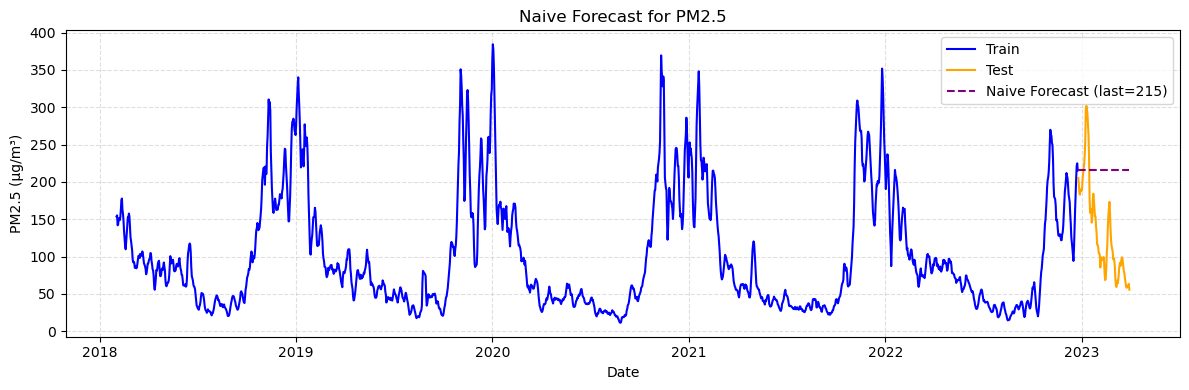

In [54]:
test_size = 96
train, test = series[:-test_size], series[-test_size:]

# Naive forecast
naive_value = train.iloc[-1]
naive_forecast = np.repeat(naive_value, test_size)

plt.figure(figsize=(12, 4))
plt.plot(train.index, train.values, label="Train", color='blue')
plt.plot(test.index, test.values, label="Test", color='orange')
plt.plot(test.index, naive_forecast, label=f"Naive Forecast (last={naive_value:.0f})", linestyle='--', color='purple')

plt.title("Naive Forecast for PM2.5")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Analysis of Results: Naive Forecast**

In the plot, the **purple dashed line** represents the naive forecast, using the last training value across all test points. However, the actual PM2.5 levels (orange) show a sharp downward trend during the forecast period. This causes the naive forecast to **overestimate** the values.

Therefore:
- The naive model is easy to use, but limited when the series changes rapidly.
- It's useful as a reference, but a better model is needed to capture seasonality and trends.

## Seasonal Naive Forecast

The **seasonal naive forecast** assumes that PM2.5 levels follow a yearly pattern. It simply takes the values from exactly **365 days earlier** and uses them as the forecast for the current period. This model is useful as a **baseline** for time series with strong seasonal cycles, especially when PM2.5 of seasonal behavior is consistent over time.


Seasonal Naive → RMSE: 59.72, MAE: 40.64


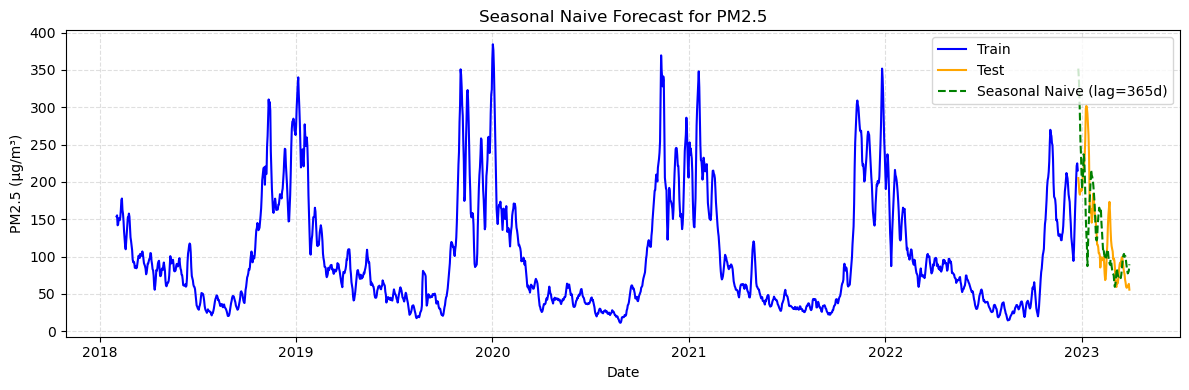

In [57]:
test_size = 96
train, test = series[:-test_size], series[-test_size:]

# Seasonal naive forecast: repeat value from 365 days ago
seasonal_lag = 365  # 1-year lag in daily data
seasonal_naive_forecast = series.shift(seasonal_lag).iloc[-test_size:]

# (optional) compute accuracy
seasonal_rmse = sqrt(mean_squared_error(test, seasonal_naive_forecast))
seasonal_mae  = mean_absolute_error(test, seasonal_naive_forecast)
print(f"Seasonal Naive → RMSE: {seasonal_rmse:.2f}, MAE: {seasonal_mae:.2f}")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(train.index, train.values, label="Train", color='blue')
plt.plot(test.index,  test.values,  label="Test",  color='orange')
plt.plot(test.index,  seasonal_naive_forecast.values,
         label=f"Seasonal Naive (lag={seasonal_lag}d)", 
         linestyle='--', color='green')

plt.title("Seasonal Naive Forecast for PM2.5")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Analysis of Results: Seasonal Naive Forecast**

The **green dashed line** represents the forecasted values copied from one year before the test period.

The model closely follows the overall seasonal pattern of PM2.5, particularly at the start of the test period. However, some mismatches occur due to changes in the actual pattern from the previous year.

Regarding Forecast Accuracy,
- **RMSE = 59.72 µg/m³**, **MAE = 40.64 µg/m³**  
  This means the forecast was, on average, about 41 µg/m³ off from the actual daily value.
- Compared to the simple naive forecast (which repeats only the last value), the seasonal naive model can better capture repeating seasonal effects, but may still struggle when year-to-year conditions differ and more advanced model needed.


## ARIMA Model

### ARIMA Model Analysis for PM2.5 Forecasting

To model and forecast PM2.5 levels, we performed time series analysis using the **ARIMA** model. 

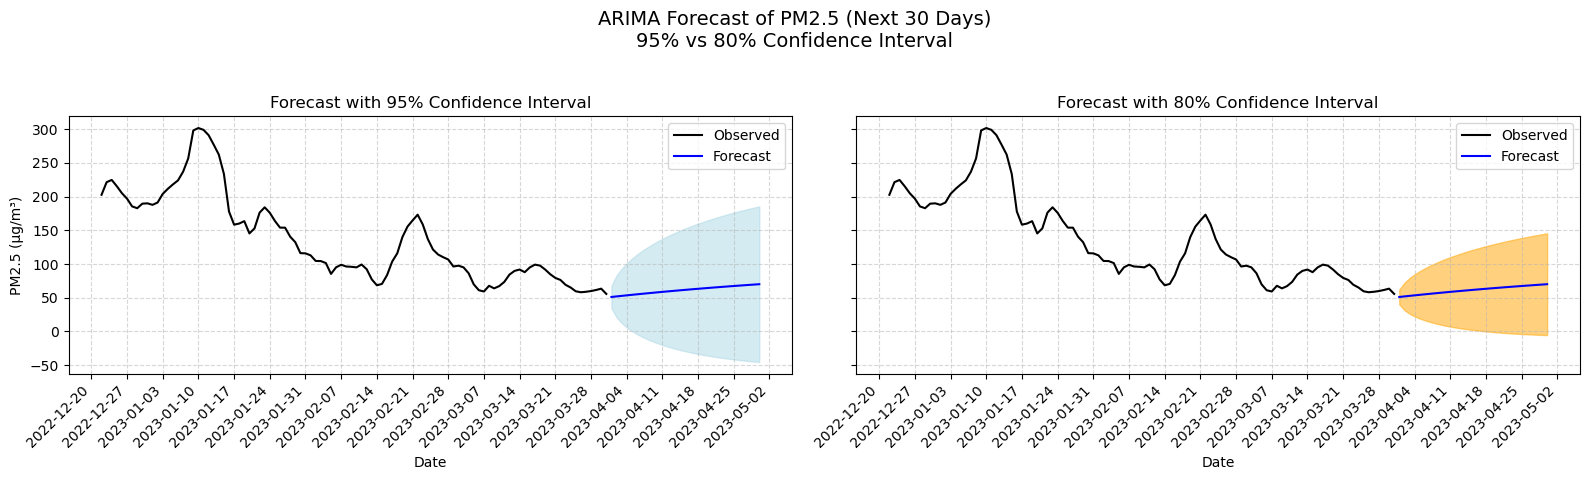

In [60]:
# Fit ARIMA
model = ARIMA(series, order=(1, 0, 1))
fitted = model.fit()

# Forecast
pred = fitted.get_forecast(steps=30)
mean = pred.predicted_mean

# Extract CI tables and convert to float
ci95 = pred.conf_int(alpha=0.05).astype(float)
ci80 = pred.conf_int(alpha=0.20).astype(float)

# Build datetime index for the forecast
last = series.index[-1]
forecast_index = pd.date_range(start=last + pd.Timedelta(days=1), periods=30, freq='D')

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

for ax, ci, title, color in zip(
    axs, [ci95, ci80],
    ["95% Confidence Interval", "80% Confidence Interval"],
    ['lightblue', 'orange']
):
    # observed + forecast line
    ax.plot(series[-100:], color='black', label='Observed')
    ax.plot(forecast_index, mean.values, color='blue', label='Forecast')
    # CI band
    lower = ci.iloc[:, 0].values
    upper = ci.iloc[:, 1].values
    ax.fill_between(forecast_index, lower, upper,
                    color=color, alpha=0.5)
    ax.set_title(f"Forecast with {title}")
    ax.set_xlabel("Date")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

    # improve x-axis ticks
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

axs[0].set_ylabel("PM2.5 (µg/m³)")
plt.suptitle("ARIMA Forecast of PM2.5 (Next 30 Days)\n95% vs 80% Confidence Interval", fontsize=14)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()


### ARIMA Forecast of PM2.5 (Next 30 Days)

The ARIMA model was trained on smoothed PM2.5 data and used to forecast the next 30 days. We made two version for confidence level, 95% and 80%.

- The **forecast line** shows a slight upward trend in PM2.5 levels.
- We can see the **95% confidence interval** is wider than the **80% confidence interval**, which is expected. As alpha values becomes smaller, the confidence level becomes wider.
- The widening of both intervals over time suggests growing uncertainty as forecasts move further from the training data.
- So the model captures general trends well, but it is **struggling for short-term pollution spikes** or abrupt events, due to the linear nature of ARIMA.

This result also suggests that our data may be non-linear and might need a better model to handle non-linear data.

### Ljung-Box Test, Residuals Plots and Histogram

After training ARIMA, we want to validate the performance so we performed Ljung-Box test at lag 10.

This is to verify that residuals behave like white noise (no significant autocorrelation).

Time series plot of residuals was made to see any non-random patterns over the forecast period.

Histogram + KDE of residuals is to check for normality and any skewness or heavy tails.

Ljung-Box Test (lag=10):
       lb_stat      lb_pvalue
10  678.489964  2.598691e-139


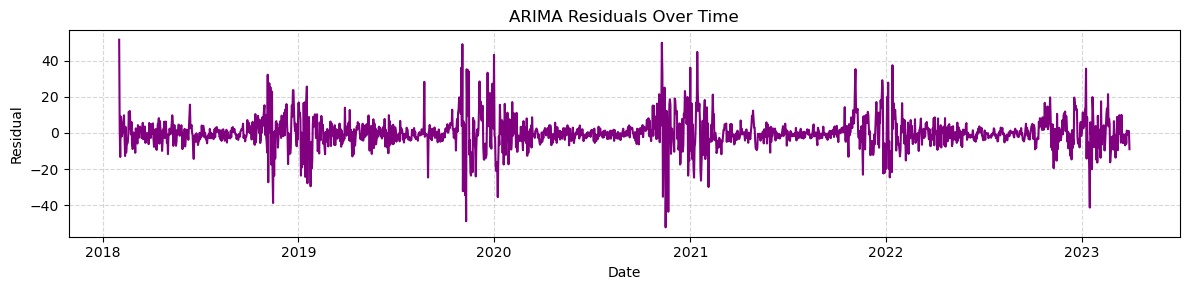

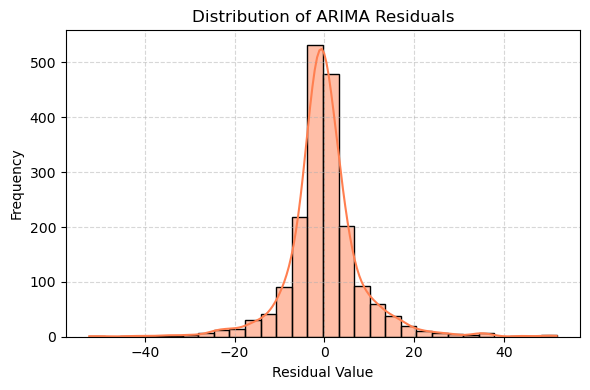

In [67]:
# Extract residuals from the final ARIMA(1,0,1) model
residuals = fitted.resid.dropna()

# Ljung-Box test (lag 10) to check for remaining autocorrelation
ljung_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test (lag=10):")
print(ljung_results)

# Plot residuals over time
plt.figure(figsize=(12, 3))
plt.plot(residuals, color='purple')
plt.title("ARIMA Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot residual distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True, color='coral')
plt.title("Distribution of ARIMA Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



#### Evaluation of ARIMA Performance

**Ljung-Box Test** at lag 10 yielded a very low p-value, and we can confidently say that the residuals are not white noise and that the model has not fully captured the autocorrelation in data.

**Residual Time Series Plot** shows clusters of high residual volatility at certain time periods, hinting at possible unmodeled dynamics or seasonal effects.

**Residual Distribution** shows that the residuals are centred on zero and roughly normal in the middle, but a heavier right tail (positive skew) hints some occasional large pollution spikes.

This suggests that a more flexible model might capture extreme events better.

While the ARIMA model captures general trends, the residual diagnostics suggest that it may not be fully adequate for prediction and need another model.

## SARIMA

Training points: 204, Testing points: 52


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                      PM2.5 (ug/m3)   No. Observations:                  204
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood                -989.760
Date:                            Thu, 26 Jun 2025   AIC                           1989.521
Time:                                    02:34:38   BIC                           2006.111
Sample:                                02-04-2018   HQIC                          1996.232
                                     - 12-26-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9460      0.025     37.880      0.000       0.897       0.995
ma.L1         -0.1882      0.060   

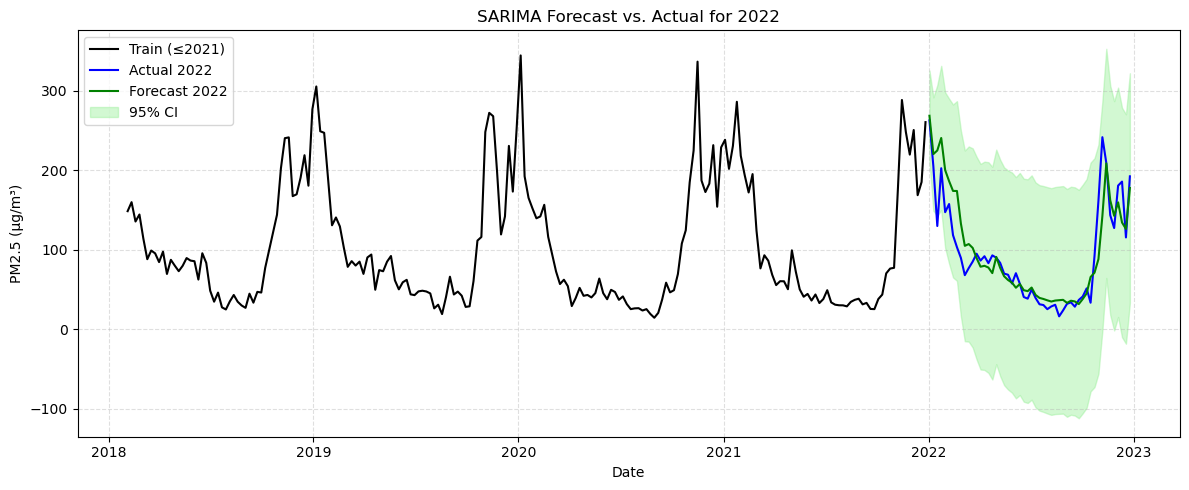

In [69]:
# Prepare the weekly series
series_weekly = (
    df['PM2.5 (ug/m3)']
    .dropna()
    .resample('D').mean()
    .interpolate('time')
    .rolling(window=7, min_periods=1).mean()
    .resample('W').mean()
)

# Split into train (up to end of 2021) and test (2022)
train = series_weekly[:'2021-12-31']
test  = series_weekly['2022']

print(f"Training points: {len(train)}, Testing points: {len(test)}")

# Fit SARIMA on the training data
model = SARIMAX(
    train,
    order=(1,0,1),
    seasonal_order=(1,0,1,52),
    enforce_stationarity=True,
    enforce_invertibility=True
)

res  = model.fit(disp=False, maxiter=50, method='powell')
print(res.summary())

# Forecast the 2022 horizon
n_steps    = len(test)
pred       = res.get_forecast(steps=n_steps)
mean_pred  = pred.predicted_mean
ci_pred    = pred.conf_int()

# Evaluate forecast accuracy
mse   = mean_squared_error(test, mean_pred)
rmse  = sqrt(mse)
mae   = mean_absolute_error(test, mean_pred)
mape  = mean_absolute_percentage_error(test, mean_pred) * 100
medae = median_absolute_error(test, mean_pred)
r2    = r2_score(test, mean_pred)

# 2) print them
print(f"2022 MSE:   {mse:.3f} µg/m³")
print(f"2022 RMSE:  {rmse:.3f} µg/m³")
print(f"2022 MAE:   {mae:.3f} µg/m³")
print(f"2022 MAPE:  {mape:.2f}%")
print(f"2022 MedAE: {medae:.3f} µg/m³")
print(f"2022 R²:    {r2:.3f}")

# Plot training, actual 2022, and forecast
plt.figure(figsize=(12, 5))
plt.plot(train.index, train,        label="Train (≤2021)", color='black')
plt.plot(test.index,  test,         label="Actual 2022",   color='blue')
plt.plot(test.index,  mean_pred,    label="Forecast 2022", color='green')
plt.fill_between(test.index,
                 ci_pred.iloc[:,0],
                 ci_pred.iloc[:,1],
                 color='lightgreen', alpha=0.4,
                 label="95% CI")
plt.title("SARIMA Forecast vs. Actual for 2022")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Interpretation of SARIMA Results**

### Model Coefficients
- **AR(1) = 0.9460**  
  This means PM2.5 levels this week are strongly related to last week’s values.
- **MA(1) = –0.1882**  
  A small adjustment for sudden changes from one week ago.
- **Seasonal AR(52) = 0.7873**  
  There is a strong yearly pattern and this week is similar to the same week last year.
- **Seasonal MA(52) = –0.3302**  
  A small correction for changes that happened a year ago.

All these values are statistically significant, so both short-term and yearly patterns matter.

---

### Residual Checks
- **Ljung–Box test (p = 0.91)**  
  No clear pattern left in the model errors (residuals), which is good.
- **Jarque–Bera (p < 0.001)**  
  The errors are not normally distributed. This might affect confidence intervals.
- **Heteroskedasticity test (p < 0.001)**  
  The size of the errors changes over time. Some periods are harder to predict.

---

### Forecast Accuracy (2022)
- **RMSE = 31.046 µg/m³**  
  On average, the forecast was off by about 31 µg/m³.
- **MAE = 20.381 µg/m³**  
  On average, the weekly forecast error was about 20 µg/m³.

This is a reasonable error range compared to the full range of PM2.5 values (which go over 300 µg/m³ at peaks).

However, R² = 0.753 is noticeably low.

---

### Forecast Plot
- The **green line** (forecast) closely follows the **blue line** (actual data), especially in early 2022.
- The **green shaded area** shows uncertainty as it is wider in the middle of the year where the data is flatter.

In general, the model does okay job of capturing both the seasonal pattern and overall trends.


## Linear Regression

### Univariate Linear Regression

This time, we applied Univariate Linear Regression to predict PM2.5. This helps evaluate how well a simple model performs compared to more complex ones like ARIMA or LSTM.

Linear Regression Performance:
  • MSE:   11.288 µg/m³
  • RMSE:  3.360 µg/m³
  • MAE:   2.460 µg/m³
  • MAPE:  3.51%
  • MedAE: 1.564 µg/m³
  • R²:    0.943


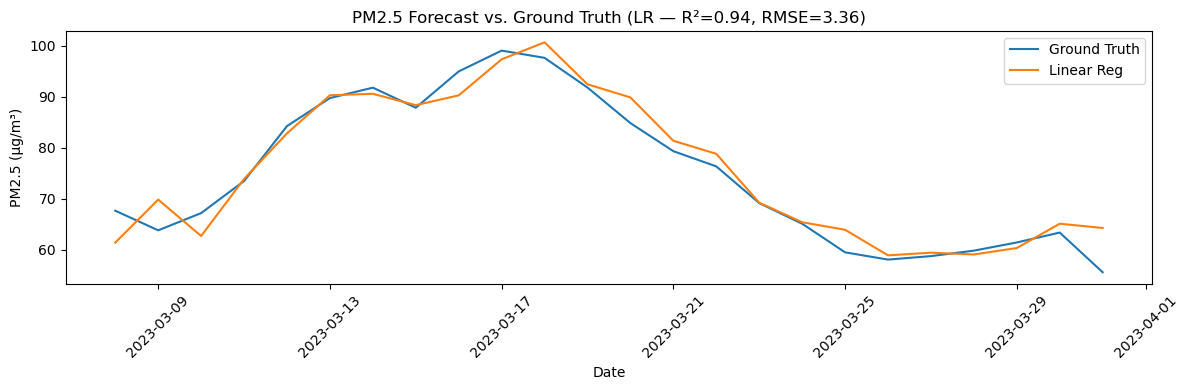

In [578]:
# Load & prepare univariate PM2.5 series
#    df_smoothed must have a DateTimeIndex and 'PM2.5 (ug/m3)' column
series = df_smoothed['PM2.5 (ug/m3)'].dropna().values.reshape(-1, 1)

# Build sliding-window features
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back].flatten())  # past look_back values
        y.append(data[i + look_back])                # next value
    return np.array(X), np.array(y)

look_back = 12
X, y = create_sequences(series, look_back)

# Train/Test split
test_size = 24  # last 24 timesteps held out
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Forecast
y_pred = lr.predict(X_test)

# Compute performance metrics
mse   = mean_squared_error(y_test, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_test, y_pred)
mape  = mean_absolute_percentage_error(y_test, y_pred) * 100
medae = median_absolute_error(y_test, y_pred)
r2    = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"  • MSE:   {mse:.3f} µg/m³")
print(f"  • RMSE:  {rmse:.3f} µg/m³")
print(f"  • MAE:   {mae:.3f} µg/m³")
print(f"  • MAPE:  {mape:.2f}%")
print(f"  • MedAE: {medae:.3f} µg/m³")
print(f"  • R²:    {r2:.3f}")

# Plot forecast vs. ground truth on real dates
forecast_dates = df_smoothed.index[-test_size:]

plt.figure(figsize=(12, 4))
plt.plot(forecast_dates, y_test,  label='Ground Truth')
plt.plot(forecast_dates, y_pred,  label='Linear Reg')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title(f"PM2.5 Forecast vs. Ground Truth (LR — R²={r2:.2f}, RMSE={rmse:.2f})")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Result**

**Univariate Linear Regression**

The low RMSE and MAE values show that the prediction error is quite small.

High R² (0.943) indicates the model explains 94.3% of the variance in PM2.5 and it means that this is a very strong fit for a linear model.


From the plot, the predicted curve tracks the overall shape of the true PM2.5 values very well, though it slightly lags or overshoots at a few turning points.

Linear regression performs surprisingly well. We wanted to see if we can improve the R² score by putting more input variables.

### Linear Regression Coefficients 

#### Model Coefficients
The numbers indicate what kind of influence they have on PM2.5

Intercept number is the base prediction when all features are zero.

**Result:**

CO is the most influential predictor of PM2.5 in this linear model.

In [581]:
coefficients = lr_model.coef_
intercept = lr_model.intercept_

for feat, coef in zip(['PM10 (ug/m3)', 'CO (mg/m3)', 'AT (degree C)'], coefficients):
    print(f"{feat}: {coef:.4f}")
print(f"Intercept: {intercept:.4f}")


PM10 (ug/m3): 0.4332
CO (mg/m3): 19.2274
AT (degree C): -3.7018
Intercept: 74.9298


### Multivariate Linear Regression and Lagged values

We added lagged features for temporal context and multiple variables (PM2.5, PM10, CO, AT) in hope to improve the model’s ability to learn.

Multivariate LR Performance:
  • MSE:   21.811 µg/m³
  • RMSE:  4.670 µg/m³
  • MAE:   3.799 µg/m³
  • MAPE:  5.46%
  • MedAE: 3.067 µg/m³
  • R²:    0.889


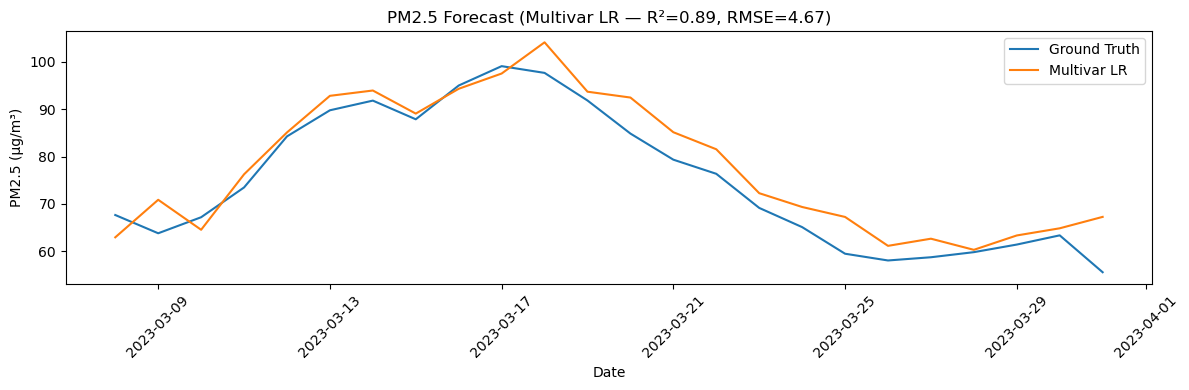

In [597]:
# Load & prepare multivariate series
data = df_smoothed[['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'CO (mg/m3)', 'AT (degree C)']].dropna()

# convert each column to numpy array
arr = data.values  # shape (T, 4)

# Build sliding-window features for all 4 vars
def create_multivar_sequences(arr, look_back=12):
    X, y = [], []
    for i in range(len(arr) - look_back):
        window = arr[i : i + look_back]     # shape (look_back, 4)
        X.append(window.flatten())          # flatten to (look_back*4,)
        y.append(arr[i + look_back, 0])     # next PM2.5 value
    return np.array(X), np.array(y)

look_back = 12
X, y = create_multivar_sequences(arr, look_back)

# Train/Test split
test_size = 24
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# scale features — helps if units differ
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train_s, y_train)

# Forecast
y_pred = lr.predict(X_test_s)

# Compute performance metrics
mse   = mean_squared_error(y_test, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_test, y_pred)
mape  = mean_absolute_percentage_error(y_test, y_pred) * 100
medae = median_absolute_error(y_test, y_pred)
r2    = r2_score(y_test, y_pred)

print("Multivariate LR Performance:")
print(f"  • MSE:   {mse:.3f} µg/m³")
print(f"  • RMSE:  {rmse:.3f} µg/m³")
print(f"  • MAE:   {mae:.3f} µg/m³")
print(f"  • MAPE:  {mape:.2f}%")
print(f"  • MedAE: {medae:.3f} µg/m³")
print(f"  • R²:    {r2:.3f}")

# Plot forecast vs. ground truth
forecast_dates = data.index[-test_size:]

plt.figure(figsize=(12,4))
plt.plot(forecast_dates, y_test,  label='Ground Truth')
plt.plot(forecast_dates, y_pred,  label='Multivar LR')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title(f"PM2.5 Forecast (Multivar LR — R²={r2:.2f}, RMSE={rmse:.2f})")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Result**

**Multivariate Linear Regression with lagged values**

An R² of 0.889 means the model explains nearly 89% of the variance in PM2.5 levels.

Low RMSE and MAE indicate small average prediction errors.

Performance is also close to good results, with far less complexity.

**Plot Interpretation**

The predicted line (orange) closely follows the ground truth (blue) but with slight overestimation around the peak and a mild lag during dips.

Trend and magnitude are well aligned and the model is robust even without deep learning.

However, adding multiple inputs and lagged values did not perform better than univariate linear regression.



## RNN

Since we have tried using linear models above, it is time to try non-linear models.

We would like to start with PM 2.5 prediction by Recurrent Neural Network (RNN).

Simple RNNs are the foundational form of recurrent neural networks. It processes sequential data by passing hidden states from one time step to next one. 

Although it is efficient for short-term patterns, they may struggle with long-term dependencies due to vanishing gradient issues.

Epoch 1/100


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 - 1s - 5ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 2/100
104/104 - 0s - 1ms/step - loss: 0.0011 - val_loss: 8.8895e-04
Epoch 3/100
104/104 - 0s - 1ms/step - loss: 7.6008e-04 - val_loss: 8.1551e-04
Epoch 4/100
104/104 - 0s - 1ms/step - loss: 7.3436e-04 - val_loss: 0.0017
Epoch 5/100
104/104 - 0s - 1ms/step - loss: 6.9246e-04 - val_loss: 8.2753e-04
Epoch 6/100
104/104 - 0s - 1ms/step - loss: 6.0472e-04 - val_loss: 7.8444e-04
Epoch 7/100
104/104 - 0s - 1ms/step - loss: 5.7733e-04 - val_loss: 6.1220e-04
Epoch 8/100
104/104 - 0s - 1ms/step - loss: 4.8866e-04 - val_loss: 5.4693e-04
Epoch 9/100
104/104 - 0s - 1ms/step - loss: 4.8018e-04 - val_loss: 9.6989e-04
Epoch 10/100
104/104 - 0s - 996us/step - loss: 4.7156e-04 - val_loss: 4.9498e-04
Epoch 11/100
104/104 - 0s - 1ms/step - loss: 4.7077e-04 - val_loss: 6.8064e-04
Epoch 12/100
104/104 - 0s - 1ms/step - loss: 4.4391e-04 - val_loss: 5.5734e-04
Epoch 13/100
104/104 - 0s - 996us/step - loss: 4.3345e-04 - val_loss: 4.6017e-04
Epoch 

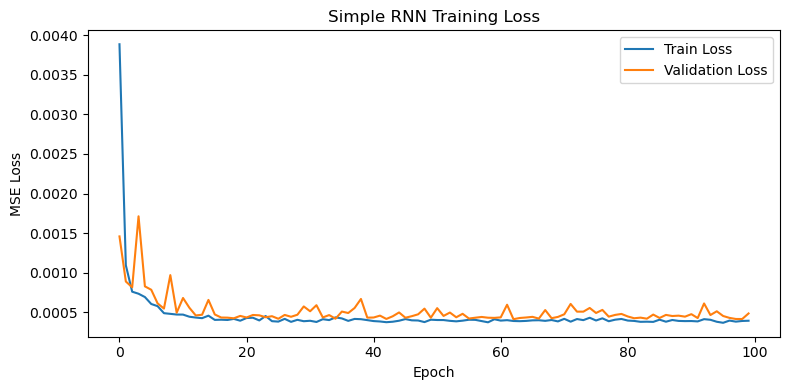

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Simple RNN Performance:
  • MSE:   18.120 µg/m³
  • RMSE:  4.257 µg/m³
  • MAE:   3.234 µg/m³
  • MAPE:  4.53%
  • MedAE: 2.502 µg/m³
  • R²:    0.908


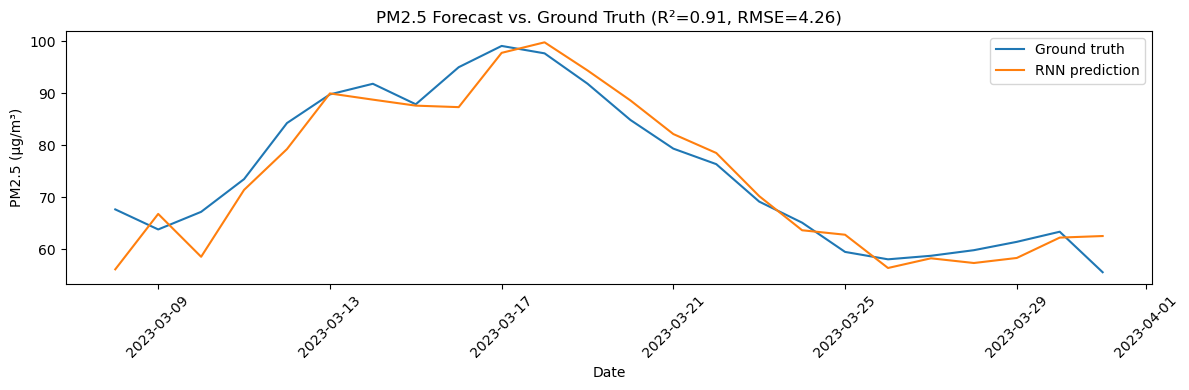

In [523]:
# Load & prepare series (must have a DateTimeIndex)
#    df_smoothed: DataFrame with datetime index & 'PM2.5 (ug/m3)' column
series = df_smoothed['PM2.5 (ug/m3)'].dropna().values.reshape(-1, 1)

# Train/Test split
test_size = 24
train, test = series[:-test_size], series[-test_size:]

# Scale to [0,1]
scaler       = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)

# Sequence builder
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_sequences(train_scaled, look_back)

# seed test sequences with last look_back points of train
combined      = np.vstack([train_scaled[-look_back:], test_scaled])
X_test, y_test = create_sequences(combined, look_back)

# reshape for RNN: (samples, timesteps, features)
X_train = X_train.reshape(-1, look_back, 1)
X_test  = X_test.reshape(-1, look_back, 1)

# Build the SimpleRNN model
model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train & capture history
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=2
)

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast on test set
y_pred_scaled = model.predict(X_test)
y_pred        = scaler.inverse_transform(y_pred_scaled)
y_true        = scaler.inverse_transform(y_test)

# Compute performance metrics
mse   = mean_squared_error(y_true, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_true, y_pred)
mape  = mean_absolute_percentage_error(y_true, y_pred) * 100
medae = median_absolute_error(y_true, y_pred)
r2    = r2_score(y_true, y_pred)

print("Simple RNN Performance:")
print(f"  • MSE:   {mse:.3f} µg/m³")
print(f"  • RMSE:  {rmse:.3f} µg/m³")
print(f"  • MAE:   {mae:.3f} µg/m³")
print(f"  • MAPE:  {mape:.2f}%")
print(f"  • MedAE: {medae:.3f} µg/m³")
print(f"  • R²:    {r2:.3f}")

# Plot forecast vs. ground truth on real dates
forecast_dates = df_smoothed.index[-test_size:]

plt.figure(figsize=(12,4))
plt.plot(forecast_dates, y_true, label='Ground truth')
plt.plot(forecast_dates, y_pred, label='RNN prediction')
plt.margins(x=0.05)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title(f"PM2.5 Forecast vs. Ground Truth (R²={r2:.2f}, RMSE={rmse:.2f})")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Result Analysis

**Simple RNN Training Loss**
- **Rapid convergence**: Both train and validation MSE drop sharply within the first 10–20 epochs.  
- **Stable plateau**: Loss stabilizes near 0.0005 by epoch 30 and remains smooth through 100 epochs, indicating no overfitting and good generalization.

**PM2.5 Forecast vs. Ground Truth**

R²: 0.91 means that our RNN Model explains 91 % of variance and it alomst successfully captures the overall trend of PM2.5 variation.
High R² and low MAE/RMSE reflect good prediction quality.

Upon visualization on the lines,

Peaks and troughs are tracked very closely—minor amplitude bias only at extreme values.  

Strong directional accuracy throughout the test window makes this **RNN well-suited for PM2.5 forecasting.**


## LSTM

To capture temporal dependencies and nonlinear patterns in the PM2.5 time series, we tried using a Long Short-Term Memory (LSTM) neural network.

LSTM is a specialized type of RNN and can capture long-range dependencies in time series data by using memory cells and gating mechanisms. 

We think it might be suitable for sequential forecasting tasks like our PM2.5 prediction since the trends span many time steps.

Epoch 1/100


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 - 1s - 10ms/step - loss: 0.0260 - val_loss: 0.0077
Epoch 2/100
104/104 - 0s - 1ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 3/100
104/104 - 0s - 2ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 4/100
104/104 - 0s - 1ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 5/100
104/104 - 0s - 1ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 6/100
104/104 - 0s - 1ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 7/100
104/104 - 0s - 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 8/100
104/104 - 0s - 1ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/100
104/104 - 0s - 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/100
104/104 - 0s - 2ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 11/100
104/104 - 0s - 1ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/100
104/104 - 0s - 1ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 13/100
104/104 - 0s - 1ms/step - loss: 9.0463e-04 - val_loss: 0.0014
Epoch 14/100
104/104 - 0s - 1ms/step - loss: 9.3582e-04 - val_loss: 9.3708e-04
Epoch 15/100
1

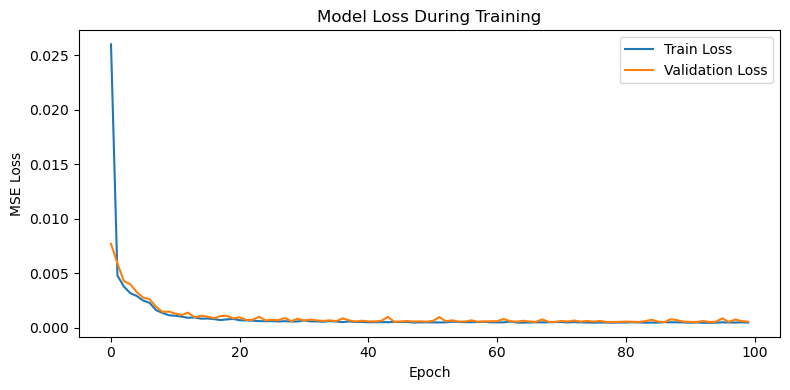

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Performance on Test Set:
  • MSE:   30.664 µg/m³
  • RMSE:  5.537 µg/m³
  • MAE:   4.604 µg/m³
  • MAPE:  6.38%
  • MedAE: 3.930 µg/m³
  • R²:    0.844


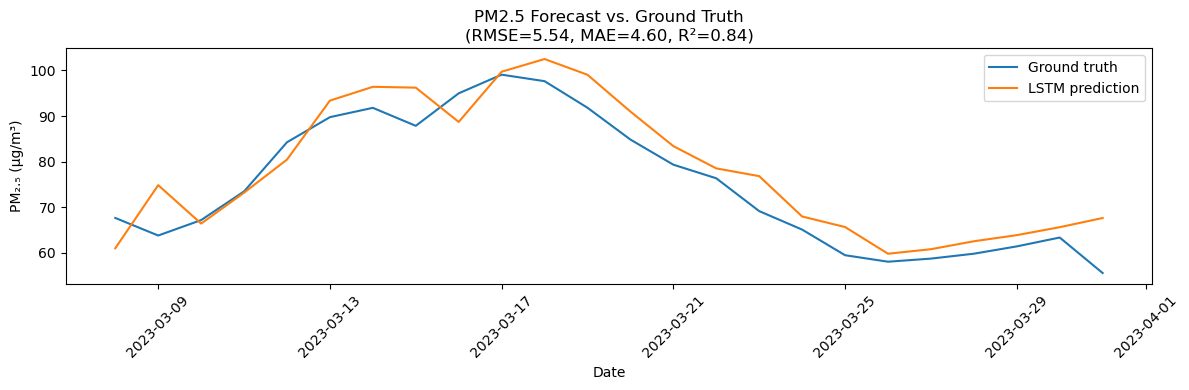

In [505]:
# df_smoothed should be a DataFrame with a datetime index and a 'PM2.5 (ug/m3)' column
series = df_smoothed['PM2.5 (ug/m3)'] \
            .dropna() \
            .values.reshape(-1, 1)

# Train/Test split
test_size = 24   # last 24 timesteps held out
train, test = series[:-test_size], series[-test_size:]

# Scale to [0,1]
scaler       = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)

# Sequence builder
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_sequences(train_scaled, look_back)

# include last look_back of train to seed the test sequences
combined   = np.vstack([train_scaled[-look_back:], test_scaled])
X_test, y_test = create_sequences(combined, look_back)

# reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape(-1, look_back, 1)
X_test  = X_test.reshape(-1, look_back, 1)

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train & capture history
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=2
)

# Plot training & validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast on test set
y_pred_scaled = model.predict(X_test)
y_pred        = scaler.inverse_transform(y_pred_scaled)
y_true        = scaler.inverse_transform(y_test)

# Compute performance metrics
mse   = mean_squared_error(y_true, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_true, y_pred)
mape  = mean_absolute_percentage_error(y_true, y_pred) * 100  # in %
medae = median_absolute_error(y_true, y_pred)
r2    = r2_score(y_true, y_pred)

print("Performance on Test Set:")
print(f"  • MSE:   {mse:.3f} µg/m³")
print(f"  • RMSE:  {rmse:.3f} µg/m³")
print(f"  • MAE:   {mae:.3f} µg/m³")
print(f"  • MAPE:  {mape:.2f}%")
print(f"  • MedAE: {medae:.3f} µg/m³")
print(f"  • R²:    {r2:.3f}")

#  Plot forecast vs. ground truth on real dates
#    build the date index for the test window
forecast_dates = df_smoothed.index[-test_size:]

plt.figure(figsize=(12, 4))
plt.plot(forecast_dates, y_true, label='Ground truth')
plt.plot(forecast_dates, y_pred, label='LSTM prediction')

# add padding
plt.margins(x=0.05)

plt.xlabel('Date')
plt.ylabel('PM₂.₅ (µg/m³)')
plt.title(
    f"PM2.5 Forecast vs. Ground Truth\n"
    f"(RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.2f})"
)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


####  Result Analysis

**Model Training Loss Curve**

Both training and validation MSE losses drop sharply within the first 10–20 epochs.

Loss values converge and stabilize near 0.0005, showing that the model learns effectively and does not overfit.

**PM2.5 Forecast vs. Ground Truth**

High R² and low MAE/RMSE reflect good prediction quality.

R² Score being 0.84 means that our LSTM Model explains 84% of variance in PM2.5 so **it almost successfully captures the overall trend of PM2.5 variation.**

We can observe that predictions follow the true values with some overestimation on peaks, but directional accuracy is strong.


## CNN

Now, we would like to try PM 2.5 prediction with 1D-CNN to see if it is better than the previous two models.

1D-CNN can extract local temporal patterns by applying convolution filters with fixed-size windows. 

They are efficient and effective for short-term trends computationally.


Epoch 1/100


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 - 0s - 5ms/step - loss: 0.0104 - val_loss: 0.0079
Epoch 2/100
104/104 - 0s - 957us/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/100
104/104 - 0s - 943us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 4/100
104/104 - 0s - 943us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 5/100
104/104 - 0s - 945us/step - loss: 9.9601e-04 - val_loss: 0.0013
Epoch 6/100
104/104 - 0s - 965us/step - loss: 8.1327e-04 - val_loss: 0.0013
Epoch 7/100
104/104 - 0s - 928us/step - loss: 8.2651e-04 - val_loss: 8.2261e-04
Epoch 8/100
104/104 - 0s - 1ms/step - loss: 7.4086e-04 - val_loss: 0.0010
Epoch 9/100
104/104 - 0s - 990us/step - loss: 6.2869e-04 - val_loss: 7.0238e-04
Epoch 10/100
104/104 - 0s - 966us/step - loss: 5.2765e-04 - val_loss: 8.3036e-04
Epoch 11/100
104/104 - 0s - 924us/step - loss: 5.4111e-04 - val_loss: 5.2907e-04
Epoch 12/100
104/104 - 0s - 931us/step - loss: 6.0368e-04 - val_loss: 0.0013
Epoch 13/100
104/104 - 0s - 945us/step - loss: 4.6827e-04 - val_loss: 7.4893e-04
Epoch 14/100
104/104

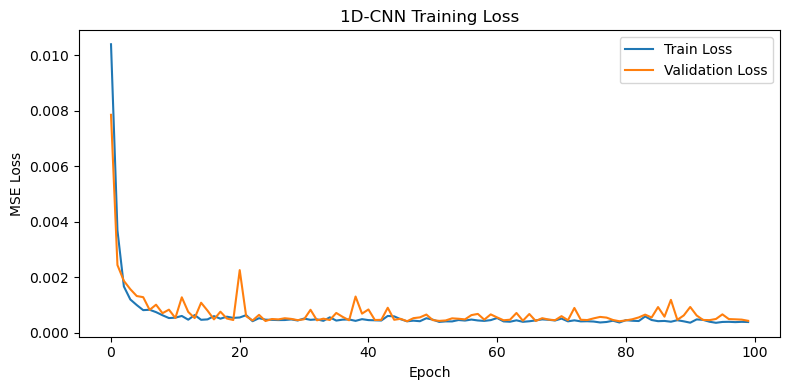

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1D-CNN Performance:
  • MSE:   14.589 µg/m³
  • RMSE:  3.820 µg/m³
  • MAE:   2.944 µg/m³
  • MAPE:  4.10%
  • MedAE: 1.983 µg/m³
  • R²:    0.926


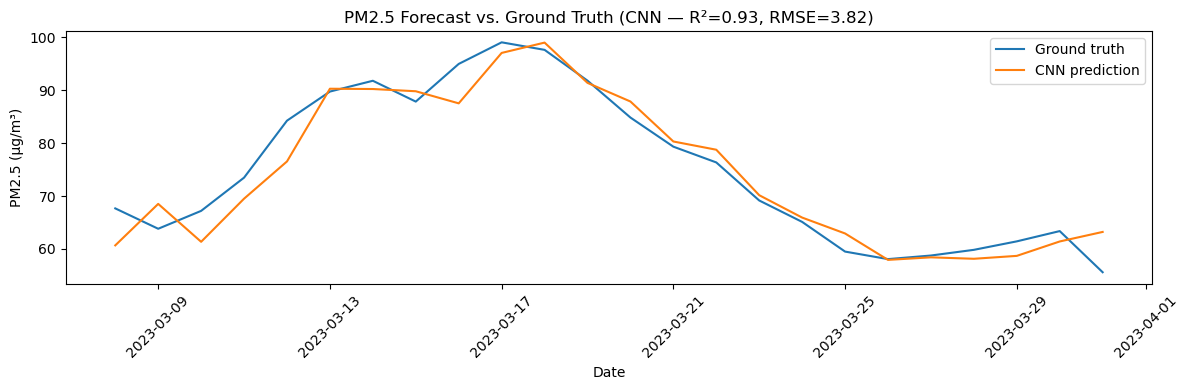

In [537]:
# Load & prepare series (must have a DateTimeIndex)
#    df_smoothed: DataFrame with datetime index & 'PM2.5 (ug/m3)' column
series = df_smoothed['PM2.5 (ug/m3)'].dropna().values.reshape(-1, 1)

# Train/Test split
test_size = 24
train, test = series[:-test_size], series[-test_size:]

# Scale to [0,1]
scaler       = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)

# Sequence builder
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_sequences(train_scaled, look_back)

# seed test sequences with last look_back points of train
combined      = np.vstack([train_scaled[-look_back:], test_scaled])
X_test, y_test = create_sequences(combined, look_back)

# reshape for Conv1D: (samples, timesteps, features)
X_train = X_train.reshape(-1, look_back, 1)
X_test  = X_test.reshape(-1, look_back, 1)

# Build the 1D-CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu',
           input_shape=(look_back, 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train & capture history
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=2
)

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('1D-CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast on test set
y_pred_scaled = model.predict(X_test)
y_pred        = scaler.inverse_transform(y_pred_scaled)
y_true        = scaler.inverse_transform(y_test)

# Compute performance metrics
mse   = mean_squared_error(y_true, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_true, y_pred)
mape  = mean_absolute_percentage_error(y_true, y_pred) * 100
medae = median_absolute_error(y_true, y_pred)
r2    = r2_score(y_true, y_pred)

print("1D-CNN Performance:")
print(f"  • MSE:   {mse:.3f} µg/m³")
print(f"  • RMSE:  {rmse:.3f} µg/m³")
print(f"  • MAE:   {mae:.3f} µg/m³")
print(f"  • MAPE:  {mape:.2f}%")
print(f"  • MedAE: {medae:.3f} µg/m³")
print(f"  • R²:    {r2:.3f}")

# Plot forecast vs. ground truth on real dates
forecast_dates = df_smoothed.index[-test_size:]

plt.figure(figsize=(12,4))
plt.plot(forecast_dates, y_true, label='Ground truth')
plt.plot(forecast_dates, y_pred, label='CNN prediction')
plt.margins(x=0.05)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title(f"PM2.5 Forecast vs. Ground Truth (CNN — R²={r2:.2f}, RMSE={rmse:.2f})")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Results

**1D-CNN Training Loss**

Training and validation MSE drop sharply in the first 10–15 epochs.  

Loss settles near 0.0003–0.0005 by epoch 20 and remains smooth through 100 epochs, indicating robust learning and no overfitting.

**PM2.5 Forecast vs. Ground Truth** 

R²: 0.926 means that our CNN Model explains 93% of variance.

The 1D-CNN achieves the **lowest errors** and **highest R²** among all tested complex models (RNN, LSTM).  

Peaks and valleys in PM2. are captured with high fidelity, with minimal amplitude bias.  

Directional accuracy is good, making the **CNN particularly well-suited for short-term forecasting.**


## MLP Models

### Standard MLP (Univariate)

We applied a Multilayer Perceptron (MLP) to predict PM2.5 levels using PM10, CO, AT because unlike linear models, MLP can model nonlinear relationship between features and the target.


Epoch 1/100


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 - 0s - 4ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 2/100
104/104 - 0s - 663us/step - loss: 9.5546e-04 - val_loss: 0.0012
Epoch 3/100
104/104 - 0s - 634us/step - loss: 8.7646e-04 - val_loss: 8.5411e-04
Epoch 4/100
104/104 - 0s - 633us/step - loss: 7.6883e-04 - val_loss: 0.0016
Epoch 5/100
104/104 - 0s - 659us/step - loss: 7.4636e-04 - val_loss: 8.4233e-04
Epoch 6/100
104/104 - 0s - 639us/step - loss: 7.8867e-04 - val_loss: 6.9704e-04
Epoch 7/100
104/104 - 0s - 665us/step - loss: 7.6793e-04 - val_loss: 0.0017
Epoch 8/100
104/104 - 0s - 804us/step - loss: 7.0526e-04 - val_loss: 0.0020
Epoch 9/100
104/104 - 0s - 797us/step - loss: 6.9943e-04 - val_loss: 6.3651e-04
Epoch 10/100
104/104 - 0s - 646us/step - loss: 6.0869e-04 - val_loss: 6.2772e-04
Epoch 11/100
104/104 - 0s - 654us/step - loss: 6.6264e-04 - val_loss: 5.5854e-04
Epoch 12/100
104/104 - 0s - 625us/step - loss: 5.5783e-04 - val_loss: 6.0642e-04
Epoch 13/100
104/104 - 0s - 676us/step - loss: 5.6481e-04 - val_loss: 6.131

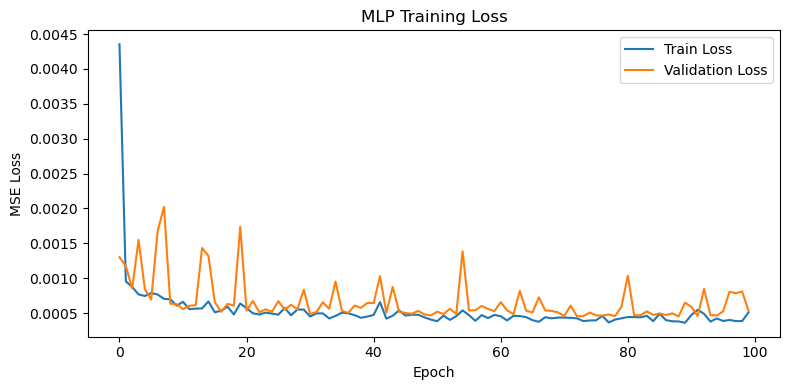

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Standard MLP Performance:
  • MSE:   21.021 µg/m³
  • RMSE:  4.585 µg/m³
  • MAE:   3.668 µg/m³
  • MAPE:  5.09%
  • MedAE: 3.165 µg/m³
  • R²:    0.893


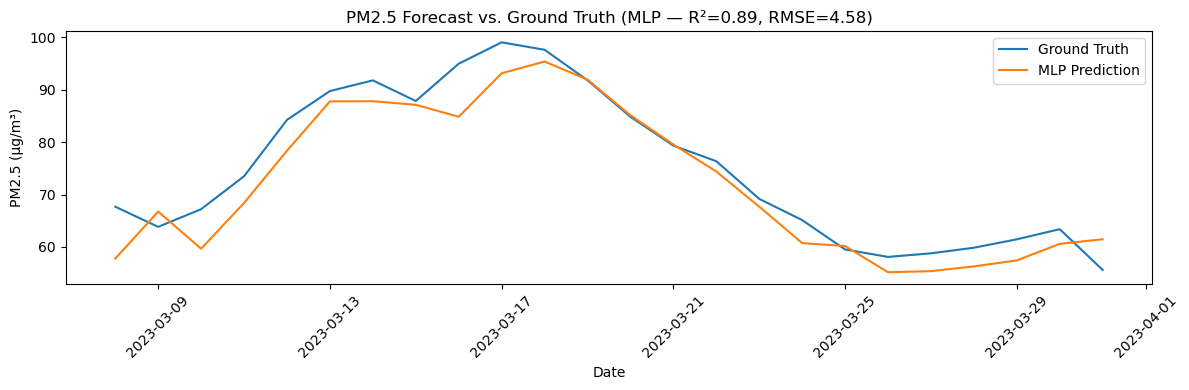

In [548]:
# Load & prepare series (must have a DateTimeIndex)
#    df_smoothed: DataFrame with datetime index & 'PM2.5 (ug/m3)' column
series = df_smoothed['PM2.5 (ug/m3)'].dropna().values.reshape(-1, 1)

# Train/Test split
test_size = 24
train, test = series[:-test_size], series[-test_size:]

# Scale to [0,1]
scaler       = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)

# Sequence builder for MLP (flattened window)
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back].flatten())
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_sequences(train_scaled, look_back)

# seed test data with last look_back points of train
combined      = np.vstack([train_scaled[-look_back:], test_scaled])
X_test, y_test = create_sequences(combined, look_back)

# Build standard MLP model
model = Sequential([
    Dense(64, activation='relu', input_dim=look_back),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train & capture history
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=2
)

# Plot training & validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MLP Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast on test set
y_pred_scaled = model.predict(X_test)
y_pred        = scaler.inverse_transform(y_pred_scaled)
y_true        = scaler.inverse_transform(y_test)

# Compute performance metrics
mse   = mean_squared_error(y_true, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_true, y_pred)
mape  = mean_absolute_percentage_error(y_true, y_pred) * 100
medae = median_absolute_error(y_true, y_pred)
r2    = r2_score(y_true, y_pred)

print("Standard MLP Performance:")
print(f"  • MSE:   {mse:.3f} µg/m³")
print(f"  • RMSE:  {rmse:.3f} µg/m³")
print(f"  • MAE:   {mae:.3f} µg/m³")
print(f"  • MAPE:  {mape:.2f}%")
print(f"  • MedAE: {medae:.3f} µg/m³")
print(f"  • R²:    {r2:.3f}")

# Plot forecast vs. ground truth on real dates
forecast_dates = df_smoothed.index[-test_size:]

plt.figure(figsize=(12, 4))
plt.plot(forecast_dates, y_true, label='Ground Truth')
plt.plot(forecast_dates, y_pred, label='MLP Prediction')
plt.margins(x=0.05)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title(f"PM2.5 Forecast vs. Ground Truth (MLP — R²={r2:.2f}, RMSE={rmse:.2f})")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Results**

**Standard MLP Training Loss**

Both training and validation loss drop within the first ~10 epochs.  

While the training loss remains consistently low, the validation loss fluctuates, suggesting some **instability or sensitivity to initialization**, but no overfitting is seen.


**PM2.5 Forecast vs. Ground Truth** 

R² being 0.89 means that our MLP Model explains 89% of the variance in PM2.5.

The standard MLP performs well in capturing general trends.  

It slightly **underestimates peaks** and **flattens local variations**, likely due to its lack of temporal memory. 

Still, it achieves strong predictive accuracy as simple baseline model for univariate forecasting.


### Multi-headed MLP

After univariate MLP, the next stop is **Multi-headed MLP**.

We loaded PM2.5 (target) and three features (PM10, CO, and AT) from dataset and build a multi-headed MLP, where each input (PM10, CO, AT) is fed through its own small neural network branch before merging them together. This combined output goes through more dense layers to predict future PM2.5 values.

Epoch 1/100
104/104 - 1s - 9ms/step - loss: 0.0086 - val_loss: 0.0046
Epoch 2/100
104/104 - 0s - 904us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/100
104/104 - 0s - 863us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 4/100
104/104 - 0s - 894us/step - loss: 9.9188e-04 - val_loss: 0.0013
Epoch 5/100
104/104 - 0s - 928us/step - loss: 9.3975e-04 - val_loss: 0.0012
Epoch 6/100
104/104 - 0s - 862us/step - loss: 8.4478e-04 - val_loss: 9.8315e-04
Epoch 7/100
104/104 - 0s - 877us/step - loss: 7.0185e-04 - val_loss: 0.0010
Epoch 8/100
104/104 - 0s - 894us/step - loss: 7.0293e-04 - val_loss: 9.7305e-04
Epoch 9/100
104/104 - 0s - 853us/step - loss: 6.2808e-04 - val_loss: 0.0010
Epoch 10/100
104/104 - 0s - 855us/step - loss: 6.5747e-04 - val_loss: 0.0012
Epoch 11/100
104/104 - 0s - 857us/step - loss: 6.1378e-04 - val_loss: 0.0014
Epoch 12/100
104/104 - 0s - 865us/step - loss: 6.5385e-04 - val_loss: 9.2623e-04
Epoch 13/100
104/104 - 0s - 852us/step - loss: 5.7240e-04 - val_loss: 0.0011
Epoch 14/1

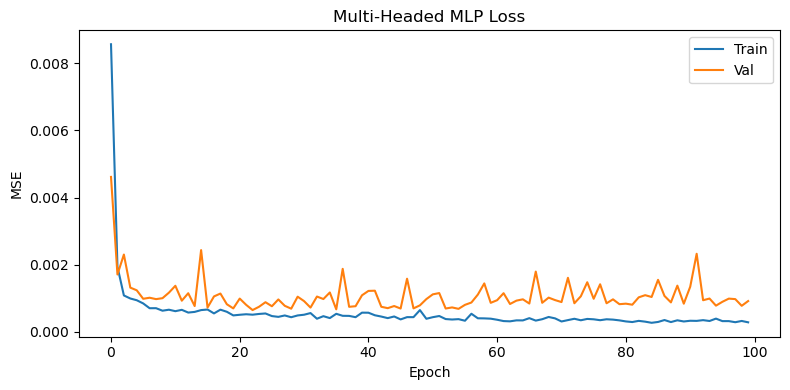

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
MSE: 18.231, RMSE: 4.270, MAE: 3.636, MAPE: 5.00%, MedAE: 3.334, R²: 0.907


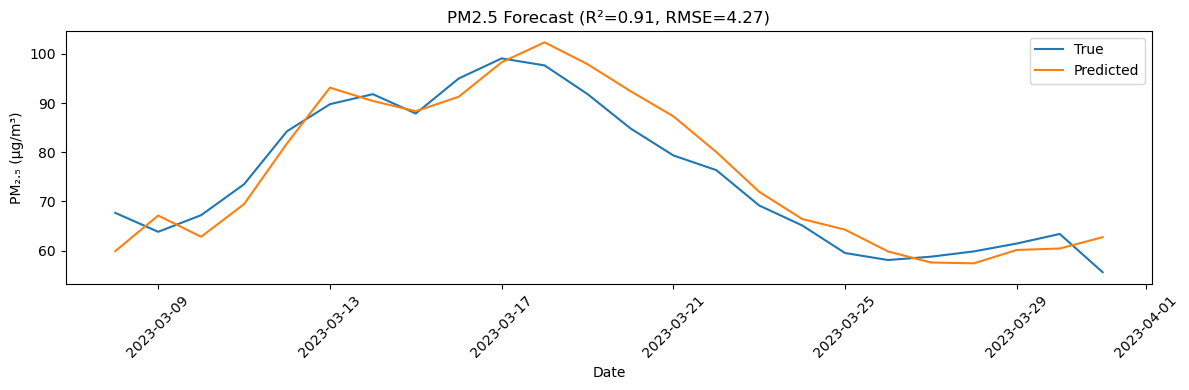

In [571]:
# Load & prepare multivariate series
data = df_smoothed[
    ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'CO (mg/m3)', 'AT (degree C)']
].dropna()

# extract each as numpy array
series_pm25 = data['PM2.5 (ug/m3)'].values.reshape(-1,1)
series_pm10 = data['PM10 (ug/m3)'].values.reshape(-1,1)
series_co   = data['CO (mg/m3)'].values.reshape(-1,1)
series_at   = data['AT (degree C)'].values.reshape(-1,1)

# Train/Test split
test_size = 24
train25, test25 = series_pm25[:-test_size], series_pm25[-test_size:]
train10, test10 = series_pm10[:-test_size], series_pm10[-test_size:]
trainco, testco = series_co[:-test_size],    series_co[-test_size:]
trainat, testat = series_at[:-test_size],    series_at[-test_size:]

# Scale each
scaler25 = MinMaxScaler(); train25_s = scaler25.fit_transform(train25); test25_s  = scaler25.transform(test25)
scaler10 = MinMaxScaler(); train10_s = scaler10.fit_transform(train10); test10_s  = scaler10.transform(test10)
scaleco  = MinMaxScaler(); trainco_s  = scaleco.fit_transform(trainco);  testco_s   = scaleco.transform(testco)
scalerat = MinMaxScaler(); trainat_s  = scalerat.fit_transform(trainat);  testat_s   = scalerat.transform(testat)

# Build sliding windows
def create_sequences(arr, look_back=12):
    X, y = [], []
    for i in range(len(arr) - look_back):
        X.append(arr[i:i+look_back])
        y.append(arr[i+look_back])
    return np.array(X), np.array(y)

look_back = 12

# train sequences
X25_tr, y_tr  = create_sequences(train25_s, look_back)
X10_tr, _     = create_sequences(train10_s, look_back)
Xco_tr, _     = create_sequences(trainco_s, look_back)
Xat_tr, _     = create_sequences(trainat_s, look_back)

# test sequences (seed with last look_back of train)
comb25 = np.vstack([train25_s[-look_back:], test25_s])
comb10 = np.vstack([train10_s[-look_back:], test10_s])
combco = np.vstack([trainco_s[-look_back:],   testco_s])
combat = np.vstack([trainat_s[-look_back:],   testat_s])

X25_te, y_te = create_sequences(comb25, look_back)
X10_te, _    = create_sequences(comb10, look_back)
Xco_te, _    = create_sequences(combco, look_back)
Xat_te, _    = create_sequences(combat, look_back)

# flatten inputs: (samples, look_back)
X25_tr = X25_tr.reshape(-1, look_back)
X10_tr = X10_tr.reshape(-1, look_back)
Xco_tr  = Xco_tr.reshape(-1, look_back)
Xat_tr  = Xat_tr.reshape(-1, look_back)

X25_te = X25_te.reshape(-1, look_back)
X10_te = X10_te.reshape(-1, look_back)
Xco_te  = Xco_te.reshape(-1, look_back)
Xat_te  = Xat_te.reshape(-1, look_back)

# Build multi-headed MLP with PM2.5 head
in25 = Input(shape=(look_back,), name='PM25_input')
x25  = Dense(32, activation='relu')(in25)
x25  = Dense(16, activation='relu')(x25)

in10 = Input(shape=(look_back,), name='PM10_input')
x10  = Dense(32, activation='relu')(in10)
x10  = Dense(16, activation='relu')(x10)

inco = Input(shape=(look_back,), name='CO_input')
xco  = Dense(32, activation='relu')(inco)
xco  = Dense(16, activation='relu')(xco)

inat = Input(shape=(look_back,), name='AT_input')
xat  = Dense(32, activation='relu')(inat)
xat  = Dense(16, activation='relu')(xat)

merged = concatenate([x25, x10, xco, xat], name='merge_heads')
x = Dense(64, activation='relu')(merged)
x = Dense(32, activation='relu')(x)
out = Dense(1, activation='linear', name='PM2.5')(x)

model = Model(inputs=[in25, in10, inco, inat], outputs=out)
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(
    {'PM25_input': X25_tr,
     'PM10_input': X10_tr,
     'CO_input':   Xco_tr,
     'AT_input':   Xat_tr},
    y_tr,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=2
)

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Multi-Headed MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(); plt.tight_layout()
plt.show()

# Forecast & inverse-scale
y_pred_s = model.predict({
    'PM25_input': X25_te,
    'PM10_input': X10_te,
    'CO_input':   Xco_te,
    'AT_input':   Xat_te
})
y_pred = scaler25.inverse_transform(y_pred_s)
y_true = scaler25.inverse_transform(y_te)

# Metrics
mse   = mean_squared_error(y_true, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_true, y_pred)
mape  = mean_absolute_percentage_error(y_true, y_pred) * 100
medae = median_absolute_error(y_true, y_pred)
r2    = r2_score(y_true, y_pred)

print(f"MSE: {mse:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%, MedAE: {medae:.3f}, R²: {r2:.3f}")

# Plot forecast vs. ground truth
dates = data.index[-test_size:]
plt.figure(figsize=(12,4))
plt.plot(dates, y_true, label='True')
plt.plot(dates, y_pred, label='Predicted')
plt.margins(x=0.05)
plt.xlabel('Date'); plt.ylabel('PM₂.₅ (µg/m³)')
plt.title(f"PM2.5 Forecast (R²={r2:.2f}, RMSE={rmse:.2f})")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.show()


**Result**

**Multi-headed MLP Training Loss**

Both train and validation loss drop sharply in the first 10–15 epochs and then plateau near 0.0004, showing the network is learning and generalizing well.  

However, alignment and stability of the two curves indicate signs of **minimal overfitting**.


**Forecast Interpretation**

R² being 0.91 means that the Multi-headed MLP Model explains 91 % of the variance.

The forecast curve closely follows both rising and falling phases, with slight amplitude shifts at extremes. 

Adding PM2.5 as an input head enables the model to anchor its predictions and deliver okay short-term forecasts although there are signs of overfitting.


# VIII Model Comparison

Now we are going to compare the performance metrics of the valid models that we did.

                   MSE   RMSE    MAE  MAPE  MedAE     R2
LinReg          11.288  3.360  2.460  3.51  1.564  0.943
MultiVar LR     21.811  4.670  3.799  5.46  3.067  0.889
Simple RNN      18.120  4.257  3.234  4.53  2.502  0.908
Test Set (ref)  30.664  5.537  4.604  6.38  3.930  0.844
1D-CNN          14.589  3.820  2.944  4.10  1.983  0.926
Standard MLP    21.021  4.585  3.668  5.09  3.165  0.893
Multi-head MLP  18.231  4.270  3.636  5.00  3.334  0.907


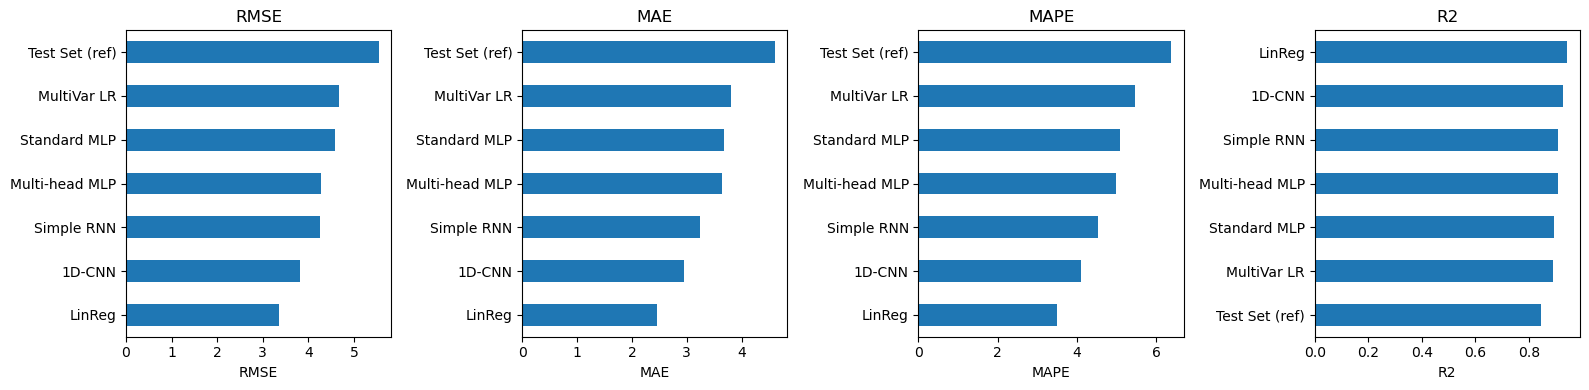

In [72]:
# Define your metrics
metrics = {
    "LinReg":             {"MSE": 11.288,  "RMSE": 3.360,  "MAE": 2.460,  "MAPE": 3.51,  "MedAE": 1.564,  "R2": 0.943},
    "MultiVar LR":        {"MSE": 21.811,  "RMSE": 4.670,  "MAE": 3.799,  "MAPE": 5.46,  "MedAE": 3.067,  "R2": 0.889},
    "Simple RNN":         {"MSE": 18.120,  "RMSE": 4.257,  "MAE": 3.234,  "MAPE": 4.53,  "MedAE": 2.502,  "R2": 0.908},
    "Test Set (ref)":     {"MSE": 30.664,  "RMSE": 5.537,  "MAE": 4.604,  "MAPE": 6.38,  "MedAE": 3.930,  "R2": 0.844},
    "1D-CNN":             {"MSE": 14.589,  "RMSE": 3.820,  "MAE": 2.944,  "MAPE": 4.10,  "MedAE": 1.983,  "R2": 0.926},
    "Standard MLP":       {"MSE": 21.021,  "RMSE": 4.585,  "MAE": 3.668,  "MAPE": 5.09,  "MedAE": 3.165,  "R2": 0.893},
    "Multi-head MLP":     {"MSE": 18.231,  "RMSE": 4.270,  "MAE": 3.636,  "MAPE": 5.00,  "MedAE": 3.334,  "R2": 0.907},
}

# Build DataFrame
df = pd.DataFrame(metrics).T
df = df[["MSE","RMSE","MAE","MAPE","MedAE","R2"]]  # ensure column order
print(df)

# Plot comparisons
metrics_to_plot = ["RMSE", "MAE", "MAPE", "R2"]
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(4*len(metrics_to_plot), 4), sharey=False)
for ax, m in zip(axes, metrics_to_plot):
    df[m].sort_values().plot.barh(ax=ax)
    ax.set_title(m)
    ax.set_xlabel(m)
plt.tight_layout()
plt.show()


We decided on Performance metrics as they help evaluate how accurately a model predicts by quantifying the difference between predicted and actual values using measures like RMSE, MAE, and R². 

Lower values for RMSE, MAE, and MAPE indicate better error performance, while a higher R² (closer to 1) means the model explains more variance in the data.

Based on consistently low errors and high R², the two best models are:

- Linear Regression (best) and 

- 1D-CNN (1D Convolutional Neural Network) (second best)

Despite its simplicity, Linear Regression achieves the best scores, while 1D-CNN offers strong performance using deep learning.

## Grid search on 1D-CNN model

We are going to perform grid search to find the best combos on 1D-CNN model to do hyperparameter optimization later.

/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=50  batch=8  diff=0 → RMSE=7.913


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=50  batch=8  diff=1 → RMSE=6.403


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=50  batch=16  diff=0 → RMSE=6.646


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=50  batch=16  diff=1 → RMSE=5.140


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=50  batch=32  diff=0 → RMSE=5.030


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=50  batch=32  diff=1 → RMSE=5.416


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=100  batch=8  diff=0 → RMSE=4.950


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=100  batch=8  diff=1 → RMSE=5.340


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=100  batch=16  diff=0 → RMSE=5.156


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=100  batch=16  diff=1 → RMSE=5.198


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=100  batch=32  diff=0 → RMSE=5.544


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=25  epochs=100  batch=32  diff=1 → RMSE=5.393


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=50  batch=8  diff=0 → RMSE=5.693


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=50  batch=8  diff=1 → RMSE=5.168


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=50  batch=16  diff=0 → RMSE=6.445


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=50  batch=16  diff=1 → RMSE=6.033


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=50  batch=32  diff=0 → RMSE=4.843


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=50  batch=32  diff=1 → RMSE=5.284


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=100  batch=8  diff=0 → RMSE=5.312


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=100  batch=8  diff=1 → RMSE=5.219


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=100  batch=16  diff=0 → RMSE=5.209


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=100  batch=16  diff=1 → RMSE=5.415


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=100  batch=32  diff=0 → RMSE=4.971


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=50  epochs=100  batch=32  diff=1 → RMSE=5.275


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=50  batch=8  diff=0 → RMSE=5.934


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=50  batch=8  diff=1 → RMSE=5.582


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=50  batch=16  diff=0 → RMSE=5.023


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=50  batch=16  diff=1 → RMSE=6.421


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=50  batch=32  diff=0 → RMSE=5.789


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=50  batch=32  diff=1 → RMSE=5.344


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=100  batch=8  diff=0 → RMSE=6.628


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=100  batch=8  diff=1 → RMSE=5.737


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=100  batch=16  diff=0 → RMSE=7.455


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=100  batch=16  diff=1 → RMSE=6.419


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=100  batch=32  diff=0 → RMSE=5.279


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=6  nodes=100  epochs=100  batch=32  diff=1 → RMSE=5.228


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=50  batch=8  diff=0 → RMSE=4.460


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=50  batch=8  diff=1 → RMSE=3.741


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=50  batch=16  diff=0 → RMSE=4.131


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=50  batch=16  diff=1 → RMSE=3.451


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=50  batch=32  diff=0 → RMSE=3.624


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=50  batch=32  diff=1 → RMSE=3.177


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=100  batch=8  diff=0 → RMSE=4.572


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=100  batch=8  diff=1 → RMSE=4.037


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=100  batch=16  diff=0 → RMSE=3.729


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=100  batch=16  diff=1 → RMSE=3.783


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=100  batch=32  diff=0 → RMSE=3.684


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=25  epochs=100  batch=32  diff=1 → RMSE=3.996


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=50  batch=8  diff=0 → RMSE=8.055


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=50  batch=8  diff=1 → RMSE=3.401


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=50  batch=16  diff=0 → RMSE=4.616


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=50  batch=16  diff=1 → RMSE=3.511


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=50  batch=32  diff=0 → RMSE=4.099


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=50  batch=32  diff=1 → RMSE=3.462


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=100  batch=8  diff=0 → RMSE=4.724


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=100  batch=8  diff=1 → RMSE=3.852


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=100  batch=16  diff=0 → RMSE=3.344


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=100  batch=16  diff=1 → RMSE=4.159


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=100  batch=32  diff=0 → RMSE=3.869


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=50  epochs=100  batch=32  diff=1 → RMSE=4.406


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=50  batch=8  diff=0 → RMSE=3.548


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=50  batch=8  diff=1 → RMSE=4.340


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=50  batch=16  diff=0 → RMSE=4.295


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=50  batch=16  diff=1 → RMSE=3.700


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=50  batch=32  diff=0 → RMSE=3.614


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=50  batch=32  diff=1 → RMSE=3.649


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=100  batch=8  diff=0 → RMSE=4.086


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=100  batch=8  diff=1 → RMSE=4.833


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=100  batch=16  diff=0 → RMSE=4.953


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=100  batch=16  diff=1 → RMSE=3.624


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=100  batch=32  diff=0 → RMSE=4.576


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=12  nodes=100  epochs=100  batch=32  diff=1 → RMSE=3.724


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=50  batch=8  diff=0 → RMSE=3.855


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=50  batch=8  diff=1 → RMSE=4.345


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=50  batch=16  diff=0 → RMSE=4.637


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=50  batch=16  diff=1 → RMSE=5.700


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=50  batch=32  diff=0 → RMSE=4.672


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=50  batch=32  diff=1 → RMSE=4.486


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=100  batch=8  diff=0 → RMSE=4.352


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=100  batch=8  diff=1 → RMSE=6.313


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=100  batch=16  diff=0 → RMSE=5.072


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=100  batch=16  diff=1 → RMSE=5.507


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=100  batch=32  diff=0 → RMSE=4.731


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=25  epochs=100  batch=32  diff=1 → RMSE=4.261


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=50  batch=8  diff=0 → RMSE=4.285


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=50  batch=8  diff=1 → RMSE=5.407


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=50  batch=16  diff=0 → RMSE=3.864


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=50  batch=16  diff=1 → RMSE=4.481


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=50  batch=32  diff=0 → RMSE=4.714


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=50  batch=32  diff=1 → RMSE=4.542


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=100  batch=8  diff=0 → RMSE=3.910


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=100  batch=8  diff=1 → RMSE=6.050


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=100  batch=16  diff=0 → RMSE=3.916


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=100  batch=16  diff=1 → RMSE=5.590


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=100  batch=32  diff=0 → RMSE=3.841


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=50  epochs=100  batch=32  diff=1 → RMSE=7.352


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=50  batch=8  diff=0 → RMSE=4.104


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=50  batch=8  diff=1 → RMSE=4.720


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=50  batch=16  diff=0 → RMSE=4.229


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=50  batch=16  diff=1 → RMSE=6.585


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=50  batch=32  diff=0 → RMSE=5.727


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=50  batch=32  diff=1 → RMSE=4.710


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=100  batch=8  diff=0 → RMSE=5.309


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=100  batch=8  diff=1 → RMSE=5.977


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=100  batch=16  diff=0 → RMSE=5.157


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=100  batch=16  diff=1 → RMSE=5.101


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=100  batch=32  diff=0 → RMSE=5.011


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


look_back=24  nodes=100  epochs=100  batch=32  diff=1 → RMSE=5.459

>>> Best config:
n_input     12.000000
n_nodes     25.000000
n_epochs    50.000000
n_batch     32.000000
n_diff       1.000000
RMSE         3.176514
Name: 41, dtype: float64


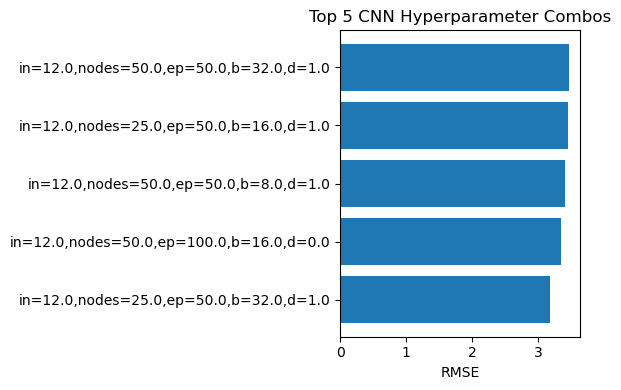

In [83]:
# Utility: differencing
def difference(series, order):
    """Flatten 1d series and apply 'order' times first‐difference."""
    arr = series.flatten()
    for _ in range(order):
        arr = np.diff(arr)
    return arr.reshape(-1, 1)

# Utility: build sequences
def create_sequences(data, look_back):
    """Exactly as your notebook: sliding window X,y pairs."""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Model factory
def build_cnn(look_back, n_nodes):
    """
    Your two‐layer Conv1D → Flatten → Dense(n_nodes) → Dense(1)
    """
    m = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(look_back, 1)),
        Conv1D(32, 3, activation='relu'),
        Flatten(),
        Dense(n_nodes, activation='relu'),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

# ——————————————————————————————————————————————————————————————————————
#  Load your smoothed PM2.5 series (exactly as in your notebook)
#    Make sure df_smoothed is already in your namespace!
raw = df_smoothed['PM2.5 (ug/m3)'].dropna().values.reshape(-1,1)

# Train/Test split params
test_size = 24

# ——————————————————————————————————————————————————————————————————————
# Define your hyper-grid
param_grid = {
    'n_input':  [6, 12, 24],
    'n_nodes':  [25, 50, 100],
    'n_epochs': [50, 100],
    'n_batch':  [8, 16, 32],
    'n_diff':   [0, 1]          # e.g. no diff or 1st‐order diff
}

# To record results
results = []

# Grid search
for n_input, n_nodes, n_epochs, n_batch, n_diff in itertools.product(*param_grid.values()):
    # Differencing
    series = difference(raw, n_diff) if n_diff else raw.copy()

    # Train/test split
    train, test = series[:-test_size], series[-test_size:]

    # Scale to [0,1]
    scaler       = MinMaxScaler()
    train_s = scaler.fit_transform(train)
    test_s  = scaler.transform(test)

    # Build sequences
    X_train, y_train = create_sequences(train_s, n_input)
    combined         = np.vstack([train_s[-n_input:], test_s])
    X_test,  y_test  = create_sequences(combined, n_input)

    # Reshape for Conv1D
    X_train = X_train.reshape(-1, n_input, 1)
    X_test  = X_test.reshape(-1, n_input, 1)

    # Build & train
    model = build_cnn(n_input, n_nodes)
    model.fit(
        X_train, y_train,
        epochs=n_epochs,
        batch_size=n_batch,
        validation_split=0.1,
        verbose=0
    )

    # Forecast & invert scaling
    y_pred_s = model.predict(X_test, verbose=0)
    y_pred   = scaler.inverse_transform(y_pred_s)
    y_true   = scaler.inverse_transform(y_test)

    # Compute RMSE
    rmse = sqrt(mean_squared_error(y_true, y_pred))

    # Record
    results.append({
        'n_input': n_input,
        'n_nodes': n_nodes,
        'n_epochs': n_epochs,
        'n_batch': n_batch,
        'n_diff': n_diff,
        'RMSE': rmse
    })

    print(f"look_back={n_input}  nodes={n_nodes}  epochs={n_epochs}"
          f"  batch={n_batch}  diff={n_diff} → RMSE={rmse:.3f}")

# Summarize best
res_df = pd.DataFrame(results)
best = res_df.sort_values('RMSE').iloc[0]
print("\n>>> Best config:")
print(best)

# Quick bar plot of the top 5 combos
top5 = res_df.nsmallest(5, 'RMSE')
plt.figure(figsize=(6,4))
plt.barh(range(len(top5)), top5['RMSE'], tick_label=[
    f"in={r.n_input},nodes={r.n_nodes},ep={r.n_epochs},b={r.n_batch},d={r.n_diff}"
    for _,r in top5.iterrows()
])
plt.xlabel('RMSE'); plt.title('Top 5 CNN Hyperparameter Combos')
plt.tight_layout()
plt.show()


**Interpretation of the results:**

The grid-search looped over every combination of

n_input (look-back window)

n_nodes (units in the dense layer)

n_epochs

n_batch

n_diff (order of differencing) in my 1d-CNN pipeline 

and reported the test-set RMSE for each. 
At the end it printed out the best configuration.
From the results above, we can see top 5 hyperparameter combos according to RMSE.

This is the best configuration:

n_input:    12

n_nodes:     25

n_epochs:    50

n_batch:    32

n_diff:       1

RMSE:         3.176514 (this is the lowest RMSE value it can get)

And we will try the best 2 parameters combo to retrain the model.

# IX Hyperparameter Tuning

This is the 1st best combo and we will apply these values to try: look back = 12, nodes = 25, epochs = 50, batch = 32, diff = 1

Epoch 1/50


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 - 0s - 9ms/step - loss: 0.0247 - val_loss: 0.0102
Epoch 2/50
52/52 - 0s - 2ms/step - loss: 0.0082 - val_loss: 0.0087
Epoch 3/50
52/52 - 0s - 1ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 4/50
52/52 - 0s - 1ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 5/50
52/52 - 0s - 1ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 6/50
52/52 - 0s - 1ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 7/50
52/52 - 0s - 1ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 8/50
52/52 - 0s - 1ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 9/50
52/52 - 0s - 1ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 10/50
52/52 - 0s - 1ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 11/50
52/52 - 0s - 1ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 12/50
52/52 - 0s - 1ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 13/50
52/52 - 0s - 1ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 14/50
52/52 - 0s - 2ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 15/50
52/52 - 0s - 1ms/step - loss: 0.0031 - val_loss: 0.0038


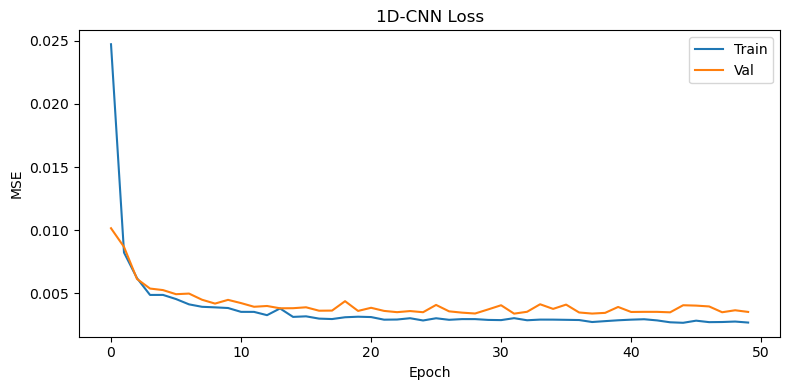

1D-CNN Performance (with n_diff):
  • MSE:   40.284 µg/m³
  • RMSE:  6.347 µg/m³
  • MAE:   5.102 µg/m³
  • MAPE:  6.27%
  • MedAE: 4.396 µg/m³
  • R²:    0.796


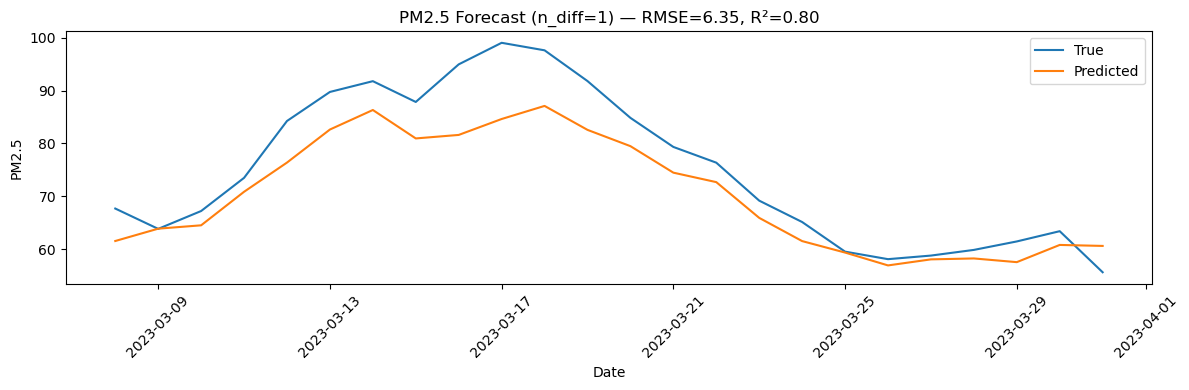

In [181]:
# ─── 1) Hyper‐parameters ──────────────────────────────────────────────
look_back, n_nodes, n_epochs, n_batch, n_diff = 12, 25, 50, 32, 1
test_size = 24

# ─── 2) Load raw PM2.5 levels ─────────────────────────────────────────
pm25 = (df_smoothed['PM2.5 (ug/m3)']
        .dropna()
        .values
        .flatten())

# ─── 3) Difference if requested ───────────────────────────────────────
if n_diff > 0:
    diffed = np.diff(pm25, n_diff)
else:
    diffed = pm25.copy()

diffed = diffed.reshape(-1, 1)

# ─── 4) Train/Test split on the differenced series ────────────────────
train_d, test_d = diffed[:-test_size], diffed[-test_size:]

# ─── 5) Scale to [0,1] ────────────────────────────────────────────────
scaler       = MinMaxScaler()
train_s      = scaler.fit_transform(train_d)
test_s       = scaler.transform(test_d)

# ─── 6) Sequence builder ──────────────────────────────────────────────
def create_sequences(data, lb):
    X, y = [], []
    for i in range(len(data) - lb):
        X.append(data[i : i + lb])
        y.append(data[i + lb])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_s, look_back)

combined         = np.vstack([train_s[-look_back:], test_s])
X_test,  y_test  = create_sequences(combined, look_back)

# ─── 7) Reshape for Conv1D ────────────────────────────────────────────
X_train = X_train.reshape(-1, look_back, 1)
X_test  = X_test.reshape(-1, look_back, 1)

# ─── 8) Build & compile the CNN ───────────────────────────────────────
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(look_back,1)),
    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dense(n_nodes, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# ─── 9) Train ─────────────────────────────────────────────────────────
history = model.fit(
    X_train, y_train,
    epochs=n_epochs,
    batch_size=n_batch,
    validation_split=0.1,
    verbose=2
)

# ─── 10) Plot loss ────────────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('1D-CNN Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.tight_layout()
plt.show()

# ─── 11) Forecast & inverse‐scale diffs ───────────────────────────────
y_pred_s   = model.predict(X_test, verbose=0)
pred_diffs = scaler.inverse_transform(y_pred_s).flatten()

# ─── 12) Invert differencing back to levels ───────────────────────────
#    seed with last known level before test
seed_level = pm25[-test_size - n_diff]
# cumulate diffs
pred_levels = np.cumsum(np.r_[seed_level, pred_diffs])[1:]

# true levels for test
true_levels = pm25[-test_size:]

# ─── 13) Compute metrics on real levels ────────────────────────────────
mse   = mean_squared_error(true_levels, pred_levels)
rmse  = sqrt(mse)
mae   = mean_absolute_error(true_levels, pred_levels)
mape  = mean_absolute_percentage_error(true_levels, pred_levels) * 100
medae = median_absolute_error(true_levels, pred_levels)
r2    = r2_score(true_levels, pred_levels)

print("1D-CNN Performance (with n_diff):")
print(f"  • MSE:   {mse:.3f} µg/m³")
print(f"  • RMSE:  {rmse:.3f} µg/m³")
print(f"  • MAE:   {mae:.3f} µg/m³")
print(f"  • MAPE:  {mape:.2f}%")
print(f"  • MedAE: {medae:.3f} µg/m³")
print(f"  • R²:    {r2:.3f}")

# ─── 14) Plot forecast vs. truth ───────────────────────────────────────
dates = df_smoothed.index[-test_size:]
plt.figure(figsize=(12,4))
plt.plot(dates, true_levels,  label='True')
plt.plot(dates, pred_levels,  label='Predicted')
plt.title(f'PM2.5 Forecast (n_diff={n_diff}) — RMSE={rmse:.2f}, R²={r2:.2f}')
plt.xlabel('Date'); plt.ylabel('PM2.5'); plt.xticks(rotation=45); plt.legend()
plt.tight_layout()
plt.show()


**1D-CNN Evaluation (Selected Metrics)**

**Hyperparameters:**  
`look_back=12`, `nodes=25`, `epochs=50`, `batch_size=32`, `n_diff=1`

---

**Performance Metrics**

- **RMSE:** **6.35 µg/m³**  

On average, predictions deviate from the true PM2.5 values by ~6.35 µg/m³. This is acceptable considering the data range and indicates moderate prediction accuracy.

- **R²:** **0.80**  

The model explains **80% of the variance** in the target variable, suggesting strong overall fit and trend capture.

**Training Loss Plot**

Smooth convergence, both training and validation loss stabilize around epoch 10–15.

No signs of overfitting.

Confirms that **50 epochs is sufficient** for training.

**Forecast Visualization**

This 1d-CNN Model successfully captures the overall rising and falling pattern of PM2.5.

Underestimation of peak values seen.

Predictions lag slightly on rapid drops, suggesting some smoothing.

Still provides a reliable trend forecast.


This is the 2nd best combo and we will apply these values to try: look back = 12, nodes = 50, epochs = 100, batch = 16, diff = 0

Epoch 1/100


/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 - 1s - 5ms/step - loss: 0.0081 - val_loss: 0.0035
Epoch 2/100
104/104 - 0s - 956us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/100
104/104 - 0s - 958us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/100
104/104 - 0s - 997us/step - loss: 9.8136e-04 - val_loss: 8.1318e-04
Epoch 5/100
104/104 - 0s - 1ms/step - loss: 8.8450e-04 - val_loss: 6.8424e-04
Epoch 6/100
104/104 - 0s - 976us/step - loss: 7.1078e-04 - val_loss: 0.0012
Epoch 7/100
104/104 - 0s - 992us/step - loss: 5.9994e-04 - val_loss: 9.0347e-04
Epoch 8/100
104/104 - 0s - 937us/step - loss: 5.3677e-04 - val_loss: 5.2513e-04
Epoch 9/100
104/104 - 0s - 950us/step - loss: 5.6945e-04 - val_loss: 6.7321e-04
Epoch 10/100
104/104 - 0s - 923us/step - loss: 6.2935e-04 - val_loss: 5.9278e-04
Epoch 11/100
104/104 - 0s - 968us/step - loss: 4.8105e-04 - val_loss: 0.0011
Epoch 12/100
104/104 - 0s - 965us/step - loss: 6.0758e-04 - val_loss: 0.0011
Epoch 13/100
104/104 - 0s - 958us/step - loss: 5.9993e-04 - val_loss: 5.6492e-04
Epoch 14

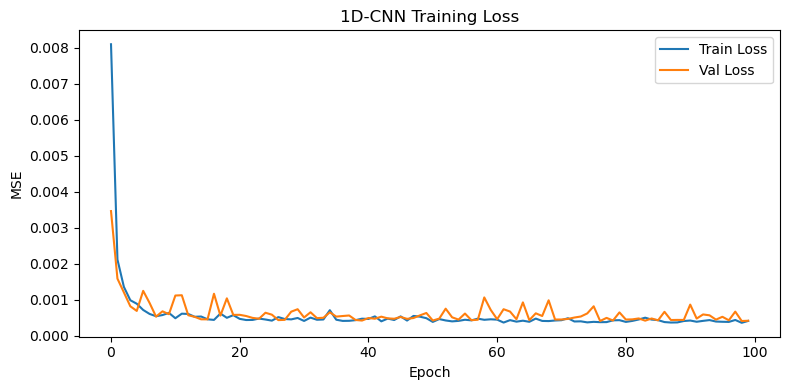

1D-CNN Performance (look_back=12, nodes=50, epochs=100, batch=16, diff=0):
  • MSE:   12.910 µg/m³
  • RMSE:  3.593 µg/m³
  • MAE:   2.751 µg/m³
  • MAPE:  3.87%
  • MedAE: 1.761 µg/m³
  • R²:    0.934


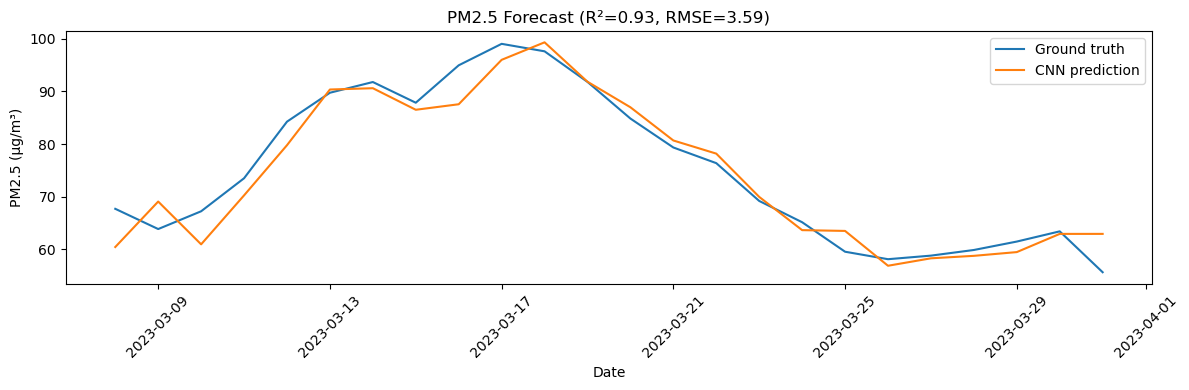

In [147]:
# ─── 1) Hyper-parameters ───────────────────────────────────────────────
look_back, n_nodes, n_epochs, n_batch, n_diff = 12, 50, 100, 16, 0
test_size = 24

# ─── 2) Load raw PM2.5 levels ───────────────────────────────────────────
pm25 = df_smoothed['PM2.5 (ug/m3)'].dropna().values.flatten()

# ─── 3) Differencing (n_diff=0 → no differencing) ──────────────────────
if n_diff > 0:
    data = np.diff(pm25, n_diff)
else:
    data = pm25.copy()
data = data.reshape(-1,1)

# ─── 4) Train/Test split on (differenced) data ─────────────────────────
train_d, test_d = data[:-test_size], data[-test_size:]

# ─── 5) Scale to [0,1] ─────────────────────────────────────────────────
scaler       = MinMaxScaler()
train_s      = scaler.fit_transform(train_d)
test_s       = scaler.transform(test_d)

# ─── 6) Sequence builder ────────────────────────────────────────────────
def create_sequences(arr, lb):
    X, y = [], []
    for i in range(len(arr) - lb):
        X.append(arr[i : i + lb])
        y.append(arr[i + lb])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_s, look_back)

combined         = np.vstack([train_s[-look_back:], test_s])
X_test,  y_test  = create_sequences(combined, look_back)

# ─── 7) reshape for Conv1D ─────────────────────────────────────────────
X_train = X_train.reshape(-1, look_back, 1)
X_test  = X_test.reshape(-1, look_back, 1)

# ─── 8) Build & compile the CNN ────────────────────────────────────────
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(look_back,1)),
    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dense(n_nodes, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# ─── 9) Train ──────────────────────────────────────────────────────────
history = model.fit(
    X_train, y_train,
    epochs=n_epochs,
    batch_size=n_batch,
    validation_split=0.1,
    verbose=2
)

# ─── 10) Plot loss ─────────────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('1D-CNN Training Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.tight_layout()
plt.show()

# ─── 11) Forecast & inverse-scale ──────────────────────────────────────
y_pred_s = model.predict(X_test, verbose=0)
y_pred   = scaler.inverse_transform(y_pred_s)
y_true   = scaler.inverse_transform(y_test)

# ─── 12) Compute metrics ───────────────────────────────────────────────
mse   = mean_squared_error(y_true, y_pred)
rmse  = sqrt(mse)
mae   = mean_absolute_error(y_true, y_pred)
mape  = mean_absolute_percentage_error(y_true, y_pred) * 100
medae = median_absolute_error(y_true, y_pred)
r2    = r2_score(y_true, y_pred)

print("1D-CNN Performance (look_back=12, nodes=50, epochs=100, batch=16, diff=0):")
print(f"  • MSE:   {mse:.3f} µg/m³")
print(f"  • RMSE:  {rmse:.3f} µg/m³")
print(f"  • MAE:   {mae:.3f} µg/m³")
print(f"  • MAPE:  {mape:.2f}%")
print(f"  • MedAE: {medae:.3f} µg/m³")
print(f"  • R²:    {r2:.3f}")

# ─── 13) Plot forecast vs. ground truth ────────────────────────────────
dates = df_smoothed.index[-test_size:]
plt.figure(figsize=(12,4))
plt.plot(dates, y_true, label='Ground truth')
plt.plot(dates, y_pred, label='CNN prediction')
plt.title(f'PM2.5 Forecast (R²={r2:.2f}, RMSE={rmse:.2f})')
plt.xlabel('Date'); plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.show()


**1D-CNN Evaluation (Selected Metrics)**

**Hyperparameters:**  
`look_back=12`, `nodes=50`, `epochs=100`, `batch_size=16`, `n_diff=0`

---

**Performance Metrics**

- **RMSE:** **3.59 µg/m³**  

On average, predictions deviate from the true PM2.5 values by ~3.59 µg/m³. This reflects high predictive accuracy within the typical range of PM2.5 fluctuations.

- **R²:** **0.93**  

The model explains **93% of the variance** in the target variable, indicating excellent model fit and strong correlation with actual observations.

**Training Loss Plot**

Losses for both training and validation sets drop rapidly and stabilize early.  

Minor fluctuations in validation loss are visible but no sign of overfitting.

Training for **100 epochs** appears appropriate given the smooth convergence.

**Forecast Visualization**

The CNN model accurately tracks the shape and direction of PM2.5 trends.  

Predicted values closely match actual values across the forecast horizon.

Minor deviations exist, but the model handles both gradual and sharp changes well, offering **reliable and interpretable forecasts**.

Although this is the 2nd best combo to use according to grid search result earlier, the perforamnce is better than the 1st best combo to use because the grid search prioritized validation loss during tuning, which doesn’t always reflect final test set generalization. Moreover, not applying differencing (n_diff=0) seemed to preserve important long-term patterns in the PM2.5 levels, leading to better performance.


## Limitations & Future Work

**Limitations**

Data scope: We used a single station data over a fixed period, so results may not generalize across Delhi’s climates or to other cities.

Feature set: Only some variables were included and calculated.

Preprocessing choices: Weekly smoothing and seasonal differencing reduce noise but can obscure short-lived spikes or abrupt pollution events.

**Future Work**

Expand exogenous variables: Incorporate wind profiles, solar radiation, or other real world indicators like traffic/industry activity, and holiday or lockdown indicators to capture more pollution drivers.

Model ensembles: Combine SARIMA, CNN, and MLP forecasts for better predictions.


# X Conclusion

In this project, we began with thorough data analysis where we computed summary statistics, plotting different variables' time series, and running tests to guide preprocessing. 

Next, we trained a seasonal-naïve benchmark, ARIMA and SARIMA model, Linear Regression models alongside four neural-network variants (Simple RNN, LSTM, 1-D CNN, and two different MLPs). 

Hyperparameters were selected via grid searches for 1d-CNN to determine best combos of look-back windows, layer sizes, filter counts, epochs, and batch sizes. 

With proper tuning, CNNs offer the most accurate short-term PM2.5 forecasts after Linear Regression although we did not fine tune LR model.
